<a href="https://colab.research.google.com/github/Djaxis/LA-PLATEFORME/blob/main/pizzaiojo_Brice_De_campos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**En effet, le Pizzaïolo a collecté des données en 2015 qu’il n’a jamais su valoriser et
utiliser à bon escient, mais ça tombe bien maintenant vous êtes là ! Il aimerait que vous
répondiez aux questions suivantes :**


➔ Quels sont les jours et les heures où nous sommes le plus occupés ?

➔ Combien de pizzas fabriquons-nous pendant les périodes de pointe ?

➔ Quelles sont les pizzas les plus vendues et les moins vendues ?

➔ Quelle est la valeur moyenne de nos commandes ?

### **EXPLORATION & IMPORT**

In [60]:
from google.colab import drive
import os.path
import pandas as pd
import csv
import json
import plotly.express as px
import requests
import seaborn as sns
import time
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import gdown
import numpy as np
from itertools import count
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from datetime import datetime, timedelta

In [61]:
######   ATTENTION wget >>>> NE TOLERE PAS LA GESTION DES TIME DATA

#!apt-get install -y wget # Installer wget
# Télécharger le fichier directement
#!wget --quiet -O 'data_model_pizza_sales.xlsx' 'https://drive.google.com/uc?id=1XOZYWBf0ldKexAybmUBCBZ8YmmF0un9o'

In [62]:
url = 'https://drive.google.com/uc?id=1XOZYWBf0ldKexAybmUBCBZ8YmmF0un9o'
output = 'data_model_pizza_sales.xlsx'
gdown.download(url, output, quiet=False)

df = pd.read_excel('data_model_pizza_sales.xlsx')

print(df.head())


Downloading...
From: https://drive.google.com/uc?id=1XOZYWBf0ldKexAybmUBCBZ8YmmF0un9o
To: /content/data_model_pizza_sales.xlsx
100%|██████████| 5.58M/5.58M [00:00<00:00, 158MB/s]


   order_details_id  order_id       pizza_id  quantity order_date order_time  \
0                 1         1     hawaiian_m         1 2015-01-01   11:38:36   
1                 2         2  classic_dlx_m         1 2015-01-01   11:57:40   
2                 3         2  five_cheese_l         1 2015-01-01   11:57:40   
3                 4         2    ital_supr_l         1 2015-01-01   11:57:40   
4                 5         2     mexicana_m         1 2015-01-01   11:57:40   

   unit_price  total_price pizza_size pizza_category  \
0       13.25        13.25          M        Classic   
1       16.00        16.00          M        Classic   
2       18.50        18.50          L         Veggie   
3       20.75        20.75          L        Supreme   
4       16.00        16.00          M         Veggie   

                                   pizza_ingredients  \
0           Sliced Ham, Pineapple, Mozzarella Cheese   
1  Pepperoni, Mushrooms, Red Onions, Red Peppers,...   
2  Mozzarella 

In [63]:
time_diff_list = []

# Boucle pour calculer la différence de temps pour chaque paire consécutive
for i in range(1, min(51, len(df))):
    time_diff = (datetime.combine(datetime.min, df.loc[i, 'order_time']) -
                 datetime.combine(datetime.min, df.loc[i - 1, 'order_time'])).total_seconds()

    # Ajouter la différence à la liste seulement si elle est différente de zéro
    if time_diff != 0:
        time_diff_list.append(time_diff)

# Créer un nouveau DataFrame avec la colonne 'diff' en secondes
diff_df = pd.DataFrame({'diff': time_diff_list})

In [64]:
print(df.columns) # affiche les colonnes
print()
print('NOMBRE DE LIGNES ET COLONNES AVEC SHAPE: ',df.shape)
print()
df.info() # informations (Column,Non-Null-Count,Dtype)
print()

Index(['order_details_id', 'order_id', 'pizza_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name'],
      dtype='object')

NOMBRE DE LIGNES ET COLONNES AVEC SHAPE:  (48620, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_details_id   48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_id           48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  object        
 9   p

In [65]:
numeric_stats = df.describe()
print("Statistiques des colonnes numériques :")
print(numeric_stats)

Statistiques des colonnes numériques :
       order_details_id      order_id      quantity    unit_price  \
count      48620.000000  48620.000000  48620.000000  48620.000000   
mean       24310.500000  10701.479761      1.019622     16.494132   
std        14035.529381   6180.119770      0.143077      3.621789   
min            1.000000      1.000000      1.000000      9.750000   
25%        12155.750000   5337.000000      1.000000     12.750000   
50%        24310.500000  10682.500000      1.000000     16.500000   
75%        36465.250000  16100.000000      1.000000     20.250000   
max        48620.000000  21350.000000      4.000000     35.950000   

        total_price  
count  48620.000000  
mean      16.821474  
std        4.437398  
min        9.750000  
25%       12.750000  
50%       16.500000  
75%       20.500000  
max       83.000000  


In [66]:
missing_values = df.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values)

Valeurs manquantes par colonne :
order_details_id     0
order_id             0
pizza_id             0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64


In [67]:
categorical_distribution = df['pizza_size'].value_counts()
print("Répartition des tailles de pizza :")
print(categorical_distribution)

Répartition des tailles de pizza :
L      18526
M      15385
S      14137
XL       544
XXL       28
Name: pizza_size, dtype: int64


In [68]:
df.head(2)

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza


In [69]:

df.tail(2)

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
48618,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
48619,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza


In [70]:
df.describe(include='all') # donne un résumé statistique rapide de toutes les colonnes

<ipython-input-70-3987441c60d8>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all') # donne un résumé statistique rapide de toutes les colonnes


,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
count,48620.000000,48620.000000,48620,48620.000000,48620,48620,48620.000000,48620.000000,48620,48620,48620,48620
unique,NaN,NaN,91,NaN,358,16382,NaN,NaN,5,4,32,32
top,NaN,NaN,big_meat_s,NaN,2015-11-26 00:00:00,12:32:00,NaN,NaN,L,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
freq,NaN,NaN,1811,NaN,261,26,NaN,NaN,18526,14579,2416,2416
first,NaN,NaN,NaN,NaN,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2015-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,24310.500000,10701.479761,NaN,1.019622,NaN,NaN,16.494132,16.821474,NaN,NaN,NaN,NaN
std,14035.529381,6180.119770,NaN,0.143077,NaN,NaN,3.621789,4.437398,NaN,NaN,NaN,NaN
min,1.000000,1.000000,NaN,1.000000,NaN,NaN,9.750000,9.750000,NaN,NaN,NaN,NaN
25%,12155.750000,5337.000000,NaN,1.000000,NaN,NaN,12.750000,12.750000,NaN,NaN,NaN,NaN


In [71]:
order_id_max = df['order_id'].max()
print("La quantité maximale d'ordre de la bdd est :", order_id_max,'commandes')

La quantité maximale d'ordre de la bdd est : 21350 commandes


### **Quels sont les jours et les heures où nous sommes le plus occupés ?**
Pour obtenir les jours les plus occupés ils nous faut compter le nombre de fois qu'apparait une date et une heure

In [72]:
df['order_date'] = pd.to_datetime(df['order_date']) # Convertir en type datetime

frequence_dates = df['order_date'].value_counts().sort_values(ascending=False) # compte de chaque date et tri en ascending
head_dates = frequence_dates.head(1)
print("LA DATE LA PLUS FREQUENTE EST :", head_dates)
print()
print('TRI DESCENDANT DES DATES PAR FREQUENCES')
frequence_dates

LA DATE LA PLUS FREQUENTE EST : 2015-11-26    261
Name: order_date, dtype: int64

TRI DESCENDANT DES DATES PAR FREQUENCES


2015-11-26    261
2015-11-27    259
2015-10-15    258
2015-07-04    233
2015-07-03    207
             ... 
2015-12-27     87
2015-11-22     82
2015-12-29     77
2015-03-22     76
2015-12-30     73
Name: order_date, Length: 358, dtype: int64

In [73]:
frequence_times = df['order_time'].value_counts().sort_values(ascending=False) # compte de chaque heure et tri en ascending
print('TRI DESCENDANT-FREQUENCES DES COMMANDES PAR H/M/SECONDES PAR')
frequence_times

TRI DESCENDANT-FREQUENCES DES COMMANDES PAR H/M/SECONDES PAR


12:32:00    26
11:59:10    24
12:53:29    23
12:52:36    23
12:26:04    23
            ..
14:55:35     1
15:38:08     1
17:26:35     1
18:45:36     1
22:09:54     1
Name: order_time, Length: 16382, dtype: int64

In [74]:
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S')

frequence_hours = df['order_time'].dt.hour.value_counts().sort_values(ascending=False)
print('LISTE DES HEURES PAR FREQUENCES')
frequence_hours

LISTE DES HEURES PAR FREQUENCES


12    6543
13    6203
18    5359
17    5143
19    4350
16    4185
14    3521
20    3487
15    3170
11    2672
21    2528
22    1370
23      68
10      17
9        4
Name: order_time, dtype: int64

In [75]:
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S')

frequence_hours = df['order_time'].dt.hour.value_counts().sort_index(ascending=True)

print('LISTE DES HEURES PAR FREQUENCES')
print(frequence_hours)

LISTE DES HEURES PAR FREQUENCES
9        4
10      17
11    2672
12    6543
13    6203
14    3521
15    3170
16    4185
17    5143
18    5359
19    4350
20    3487
21    2528
22    1370
23      68
Name: order_time, dtype: int64


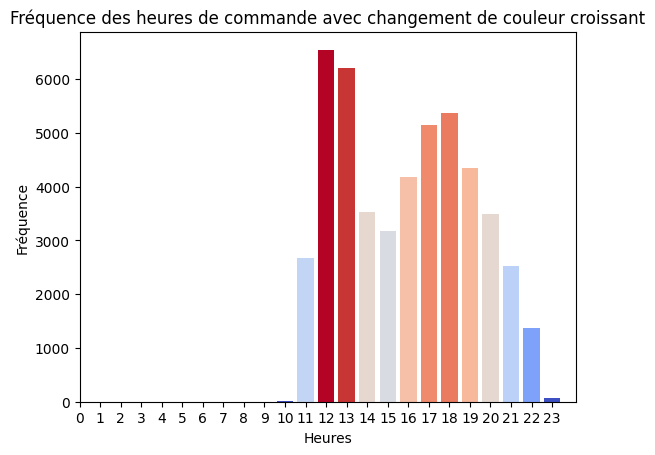

In [76]:
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S')

frequence_hours = df['order_time'].dt.hour.value_counts().sort_index(ascending=True)

normalized_values = (frequence_hours - frequence_hours.min()) / (frequence_hours.max() - frequence_hours.min())

# Exclure les heures avec une fréquence nulle
frequence_hours = frequence_hours[frequence_hours != 0]

colors = plt.cm.coolwarm(normalized_values)  # Utiliser la colormap coolwarm
plt.bar(frequence_hours.index, frequence_hours.values, color=colors)

plt.xlabel('Heures')
plt.ylabel('Fréquence')
plt.title('Fréquence des heures de commande avec changement de couleur croissant')

plt.xticks(range(24))  # Utiliser toutes les heures distinctes sur l'axe x
plt.show()

In [77]:
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S')

df['rounded_order_time'] = df['order_time'].dt.floor('30min')

frequence_half_hours = df['rounded_order_time'].dt.time.value_counts().sort_index(ascending=True)
frequence_half_hours

09:30:00       4
10:00:00       1
10:30:00      16
11:00:00     499
11:30:00    2173
12:00:00    3057
12:30:00    3486
13:00:00    3478
13:30:00    2725
14:00:00    1935
14:30:00    1586
15:00:00    1588
15:30:00    1582
16:00:00    1930
16:30:00    2255
17:00:00    2466
17:30:00    2677
18:00:00    2684
18:30:00    2675
19:00:00    2248
19:30:00    2102
20:00:00    1912
20:30:00    1575
21:00:00    1422
21:30:00    1106
22:00:00     980
22:30:00     390
23:00:00      68
Name: rounded_order_time, dtype: int64

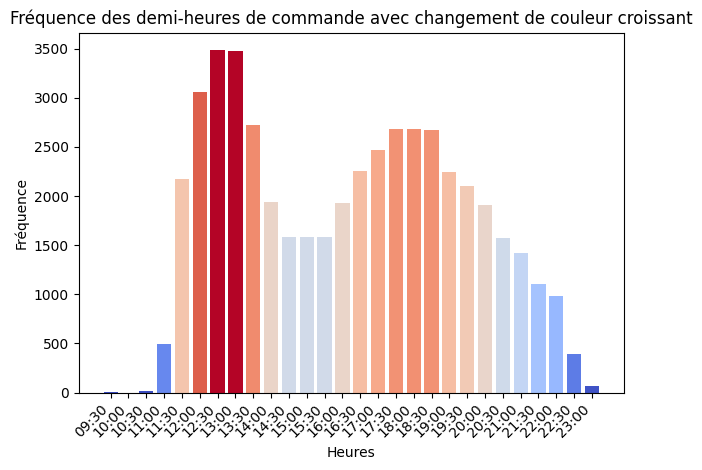

In [78]:
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S')

df['rounded_order_time'] = df['order_time'].dt.floor('30min')

# Extraire les heures arrondies
frequence_half_hours = df['rounded_order_time'].dt.time.value_counts().sort_index(ascending=True)

# Formater les étiquettes de l'axe x pour exclure les secondes
formatted_labels = [time.strftime('%H:%M') for time in frequence_half_hours.index]

# Normaliser les valeurs de fréquence entre 0 et 1
normalized_values = (frequence_half_hours - frequence_half_hours.min()) / (frequence_half_hours.max() - frequence_half_hours.min())

colors = plt.cm.coolwarm(normalized_values)  # Utiliser la colormap coolwarm
plt.bar(formatted_labels, frequence_half_hours.values, color=colors)

plt.xlabel('Heures')
plt.ylabel('Fréquence')
plt.title('Fréquence des demi-heures de commande avec changement de couleur croissant')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **2. Informations de base :**


a. Combien de pizzas uniques (pizza_id distincts) y a-t-il dans le jeu de
données ?


In [79]:
nombre_de_pizzas_uniques = len(df['pizza_id'].unique())
print('Nombre de pizza unique est  :',nombre_de_pizzas_uniques, ' en prenant en compte toutes les tailles.')

Nombre de pizza unique est  : 91  en prenant en compte toutes les tailles.


\b. Combien de commandes uniques (order_id distincts) figurent dans le jeu
de données ? **texte en gras**

Nombre de commandes sur l'année 2015 unique est : 21350

La synthèse des résultats montre deux mois avec les valeurs les plus basses pour le nombre de commandes uniques en 2015 :

Septembre 2015 : 1661 commandes uniques
Octobre 2015 : 1646 commandes uniques **texte en gras**


**Pour augmenter les ventes pendant les mois les plus bas (Septembre et Octobre) :**

**Promotion des Produits Populaires : **Identifiez les produits les plus populaires des mois forts et proposez des promotions spéciales pendant les mois faibles.

**Campagnes Marketing Ciblées :** Lancez des campagnes publicitaires et e-mails ciblés pour attirer de nouveaux clients pendant les mois plus faibles.

**Programmes de Fidélité :** Mettez en place des programmes de fidélité avec des récompenses spéciales pour inciter les clients existants à acheter.

**Analyse des Données Clients :** Analysez les données clients pour personnaliser les offres en fonction des comportements d'achat pendant les mois faibles.

**Promotions Événementielles :** Organisez des événements spéciaux, des ventes flash, ou des promotions exclusives pour stimuler l'enthousiasme et encourager les achats.

Nombre de commandes sur l'année 2015 unique est : 21350


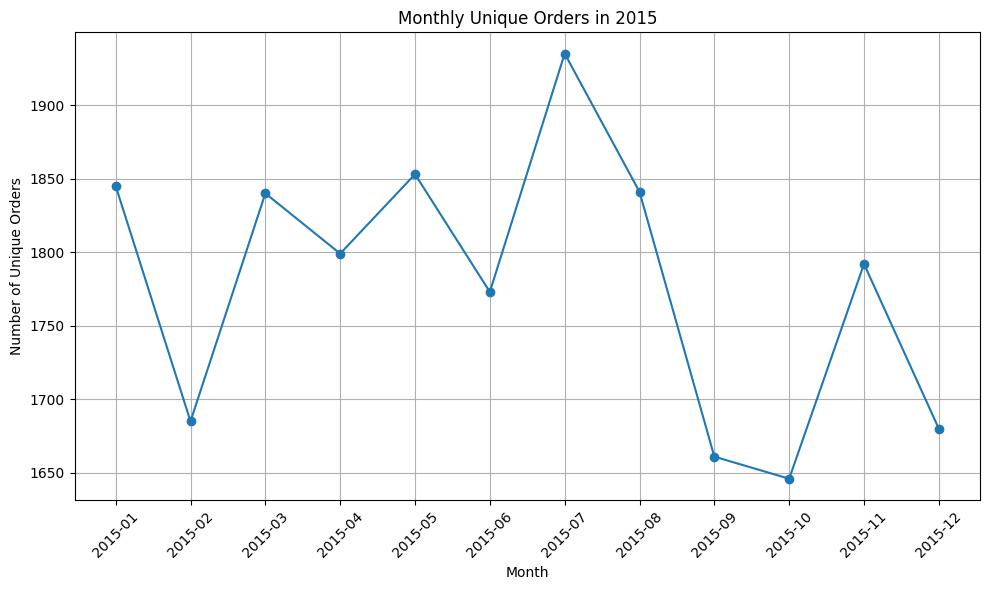

              Month  Unique Orders
year_month                        
2015-01     2015-01           1845
2015-02     2015-02           1685
2015-03     2015-03           1840
2015-04     2015-04           1799
2015-05     2015-05           1853
2015-06     2015-06           1773
2015-07     2015-07           1935
2015-08     2015-08           1841
2015-09     2015-09           1661
2015-10     2015-10           1646
2015-11     2015-11           1792
2015-12     2015-12           1680


In [80]:
commandes_uniques = len(df['order_id'].unique())
print('Nombre de commandes sur l\'année 2015 unique est :', commandes_uniques)

df['order_date'] = pd.to_datetime(df['order_date'])
df['year_month'] = df['order_date'].dt.to_period('M')
monthly_unique_orders = df.groupby('year_month')['order_id'].nunique()
plt.figure(figsize=(10, 6))
plt.plot(monthly_unique_orders.index.astype(str), monthly_unique_orders, marker='o', linestyle='-')
plt.title('Monthly Unique Orders in 2015')
plt.xlabel('Month')
plt.ylabel('Number of Unique Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Affichage des résultats des points du graphique
results = pd.DataFrame({'Month': monthly_unique_orders.index.astype(str), 'Unique Orders': monthly_unique_orders})
print(results.head(50))

### **3. Analyse temporelle :**



a. Quelle est la plage de dates dans le jeu de données ?


La Plage de Date "dans le jeu de données"  est de : 2015-01-01 00:00:00 à 2015-12-31 00:00:00

LA PLAGE OU LE NOMBRE DE DATES "dans le jeu de données"  EST DE :  358 DATES



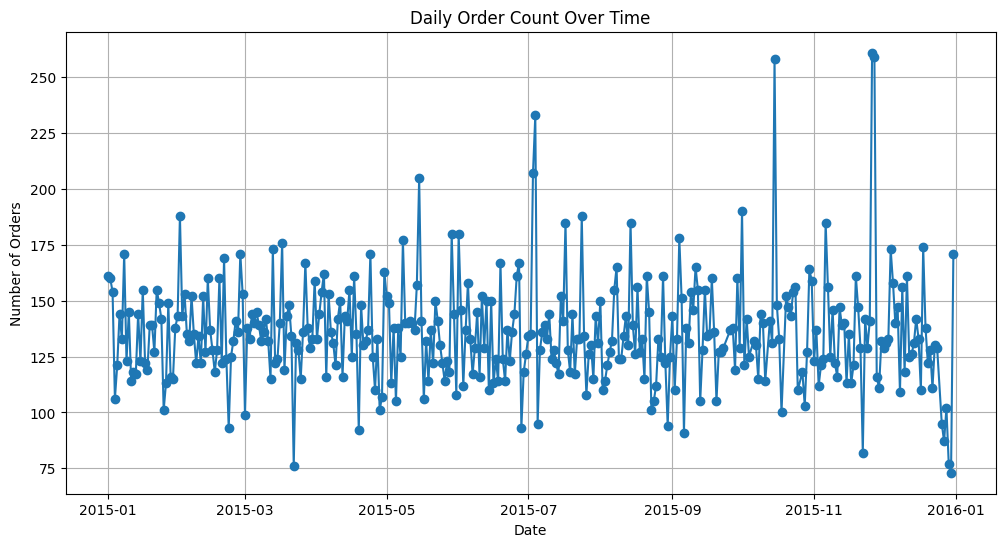

In [81]:
df['order_date'] = pd.to_datetime(df['order_date'])
debut = df['order_date'].min()
fin = df['order_date'].max()
print('La Plage de Date "dans le jeu de données"  est de :', debut, 'à', fin)
print()
plage_dates = len(df['order_date'].value_counts().sort_values(ascending=False))
print('LA PLAGE OU LE NOMBRE DE DATES "dans le jeu de données"  EST DE : ',plage_dates, 'DATES')
print()
df['order_date'] = pd.to_datetime(df['order_date'])
daily_order_count = df.groupby('order_date').size()
plt.figure(figsize=(12, 6))
plt.plot(daily_order_count.index, daily_order_count.values, marker='o', linestyle='-')
plt.title('Daily Order Count Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

b. Combien de commandes ont été passées chaque jour ?

    order_date  order_id
0   2015-01-01        69
1   2015-01-02        67
2   2015-01-03        66
3   2015-01-04        52
4   2015-01-05        54
..         ...       ...
353 2015-12-27        35
354 2015-12-28        39
355 2015-12-29        27
356 2015-12-30        32
357 2015-12-31        73

[358 rows x 2 columns]


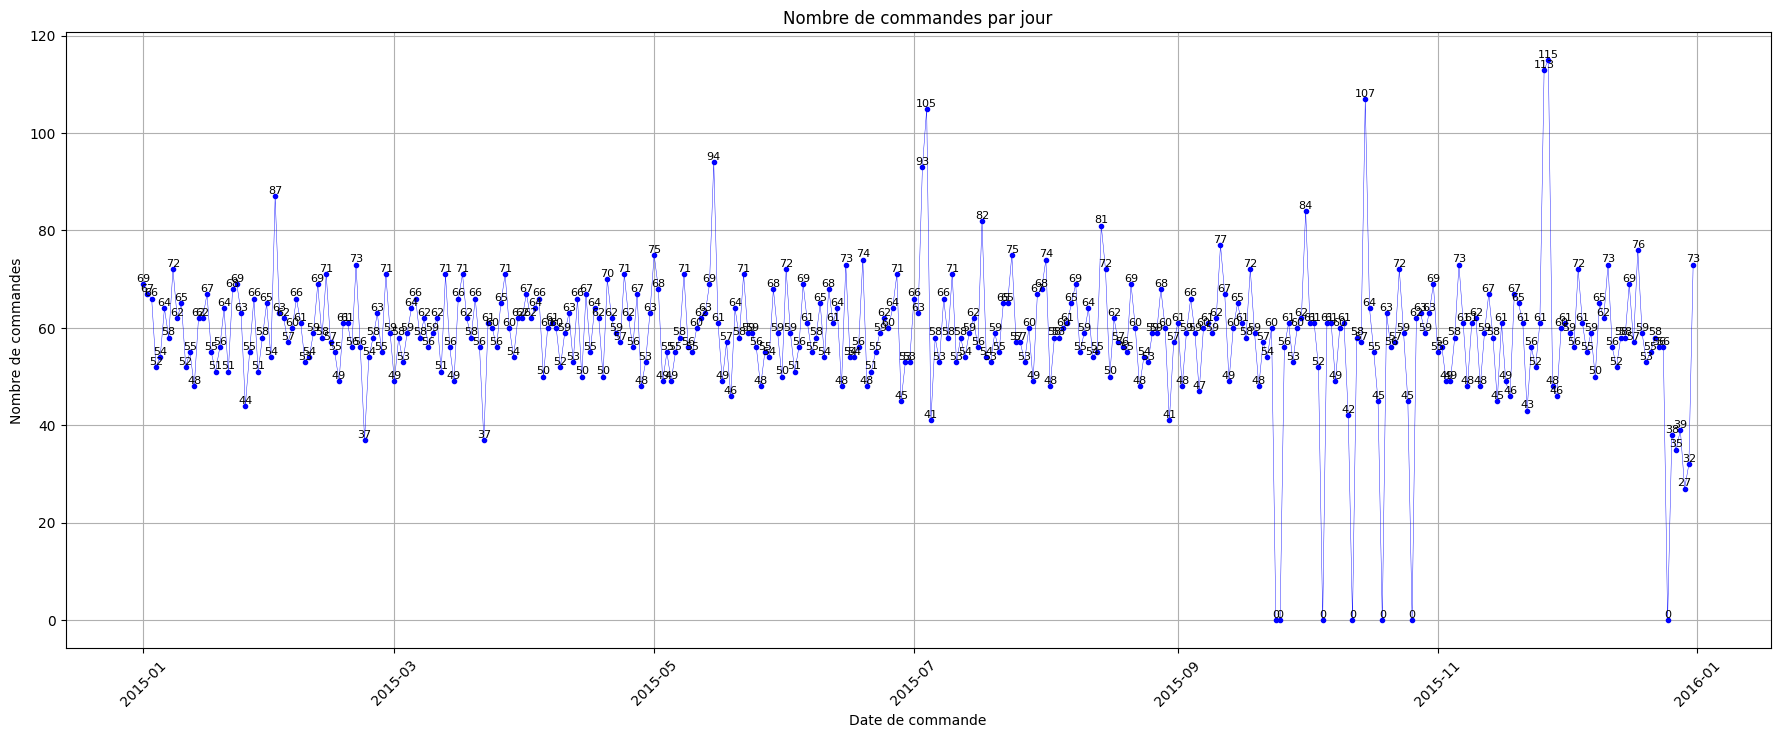

In [82]:
df['order_date'] = pd.to_datetime(df['order_date'])
date_range = pd.date_range(start=df['order_date'].min(), end=df['order_date'].max(), freq='D')
all_dates_df = pd.DataFrame(index=date_range)
nombre_de_commandes_par_jour = df.groupby('order_date')['order_id'].nunique().reset_index()
print(nombre_de_commandes_par_jour)

merged_df = pd.merge(all_dates_df, nombre_de_commandes_par_jour.reset_index(), left_index=True, right_on='order_date', how='left')
merged_df['order_id'] = merged_df['order_id'].fillna(0)

plt.figure(figsize=(22, 8))
plt.plot(merged_df['order_date'], merged_df['order_id'], marker='.', linestyle='-', color='b', linewidth=0.3)
plt.title('Nombre de commandes par jour')
plt.xlabel('Date de commande')
plt.ylabel('Nombre de commandes')
plt.xticks(rotation=45)  # Pivoter les étiquettes des jours
plt.grid(True)

#chiffre sur le plot
for date, orders in zip(merged_df['order_date'], merged_df['order_id']):
    plt.text(date, orders + 0.1, str(int(orders)), ha='center', va='bottom', fontsize=8)
plt.show()

**c. Quelle est la durée moyenne pour traiter une commande ?**

Il n'y a pas de donnéess permettant de statuer

On peut tenter d'obtenir la moyenne des différences entre chaque Order_id, afin d'avoir un ordre d'idée intuitif.

On peut donc proposer d'optimiser la production de chaque commande sur cette moyenne à ne pas dépasser au risque sur le déroulement, processus jusqu'à livraison. On modifiera le nombre d'entrées.

In [83]:
import pandas as pd
from datetime import datetime, timedelta

time_diff_list = []


df['order_time'] = pd.to_datetime(df['order_time'])

# Calcul différence de temps pour chaque paire consécutive
for i in range(1, min(27, len(df))):
    time_diff = (df.loc[i, 'order_time'] - df.loc[i - 1, 'order_time']).total_seconds()

    # Ajouter la différence à la liste si différente de zéro
    if time_diff != 0:
        time_diff_list.append(time_diff)

# Créer un nouveau DataFrame avec la colonne 'diff' en secondes
diff_df = pd.DataFrame({'diff': time_diff_list})

# Ajouter une nouvelle colonne 'diff_formatted' au format heures:minutes:secondes
diff_df['diff_formatted'] = diff_df['diff'].apply(lambda x: str(timedelta(seconds=x)))

# Afficher la nouvelle colonne
print(diff_df['diff_formatted'])

# Calculer le temps moyen en secondes
mean_time_seconds = diff_df['diff'].mean()

# Afficher le temps moyen en heures:minutes:secondes
mean_time_formatted = str(timedelta(seconds=mean_time_seconds))
print("Temps moyen entre les commandes : {}".format(mean_time_formatted))

0    0:19:04
1    0:14:48
2    0:04:03
3    0:04:59
4    0:08:06
5    0:21:01
6    0:01:00
7    0:00:24
8    0:08:14
9    0:02:44
Name: diff_formatted, dtype: object
Temps moyen entre les commandes : 0:08:26.300000


### **4. Analyse de la quantité :**


a. Quelle est la quantité moyenne de pizzas commandées ?


In [84]:

nombre_de_commandes_uniques = len(df['order_id'].unique())
print('Nombre total de commandes uniques :', nombre_de_commandes_uniques)

nbr_total_pizza_order_2015 = df['quantity'].sum()
print('Total de pizza commandée :',nbr_total_pizza_order_2015)


quantity_moyenne_pizzas_command = nbr_total_pizza_order_2015 / nombre_de_commandes_uniques

print('Quantity_moyenne_pizzas_command : ', quantity_moyenne_pizzas_command)

Nombre total de commandes uniques : 21350
Total de pizza commandée : 49574
Quantity_moyenne_pizzas_command :  2.321967213114754


In [85]:
quantity_moyenne_pizzas_command2 = df.groupby('order_id')['quantity'].sum().mean()
print('Quantity_moyenne_pizzas_command : ', quantity_moyenne_pizzas_command2)

Quantity_moyenne_pizzas_command :  2.321967213114754


b. Quelle est la taille de pizza la plus fréquemment commandée ?


La taille 'L' est la plus fréquemment commandée parmi cinq tailles différentes.

Globalement, il semble y avoir une tendance à commander des tailles plus petites, avec des diminutions significatives pour les tailles 'XL' et 'XXL', indiquant une préférence générale pour des tailles de pizza plus petites.

Liste des différentes tailles : ['M' 'L' 'S' 'XL' 'XXL']

Nombre des différentes tailles : 5

L      18526
M      15385
S      14137
XL       544
XXL       28
Name: pizza_size, dtype: int64

Taille la plus fréquemment commandée  : L


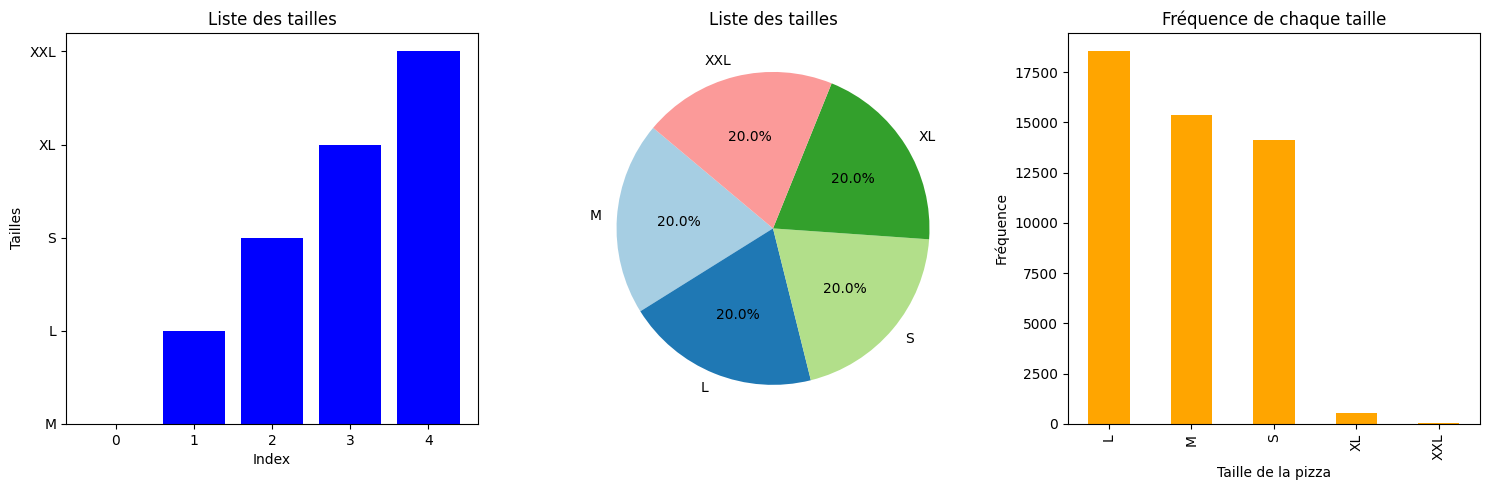

In [126]:
list_size = df['pizza_size'].unique()
print('Liste des différentes tailles :', list_size)
print()
nbre_size = len(df['pizza_size'].unique())
print('Nombre des différentes tailles :', nbre_size)
print()
pizza_size_freq = df['pizza_size'].value_counts()
print(pizza_size_freq)
print()
most_frequent_size = pizza_size_freq.idxmax()
print('Taille la plus fréquemment commandée  :', most_frequent_size)

# Supposons que df est votre DataFrame

# Données
list_size = df['pizza_size'].unique()
nbre_size = len(list_size)
pizza_size_freq = df['pizza_size'].value_counts()
most_frequent_size = pizza_size_freq.idxmax()

# Créer une nouvelle figure
plt.figure(figsize=(15, 5))

# Graphique 1 : Liste des différentes tailles (Barres)
plt.subplot(1, 3, 1)
plt.bar(range(len(list_size)), list_size, color='blue')
plt.title('Liste des tailles')
plt.xlabel('Index')
plt.ylabel('Tailles')

# Graphique 2 : Liste des différentes tailles (Camembert)
plt.subplot(1, 3, 2)
plt.pie([1] * len(list_size), labels=list_size, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Liste des tailles')

# Graphique 3 : Fréquence de chaque taille (Barres)
plt.subplot(1, 3, 3)
pizza_size_freq.plot(kind='bar', color='orange')
plt.title('Fréquence de chaque taille')
plt.xlabel('Taille de la pizza')
plt.ylabel('Fréquence')

# Ajuster la disposition pour éviter les chevauchements
plt.tight_layout()

# Afficher les graphiques
plt.show()

c. Quelle est la catégorie de pizza la plus fréquemment commandée ?

VISUALISATION : 
Classic    14579
Supreme    11777
Veggie     11449
Chicken    10815
Name: pizza_category, dtype: int64


La catégorie de pizza la plus fréquemment commandée  : Classic

Catégorie de pizza la plus fréquemment commandée(s) : 0    Classic
Name: pizza_category, dtype: object



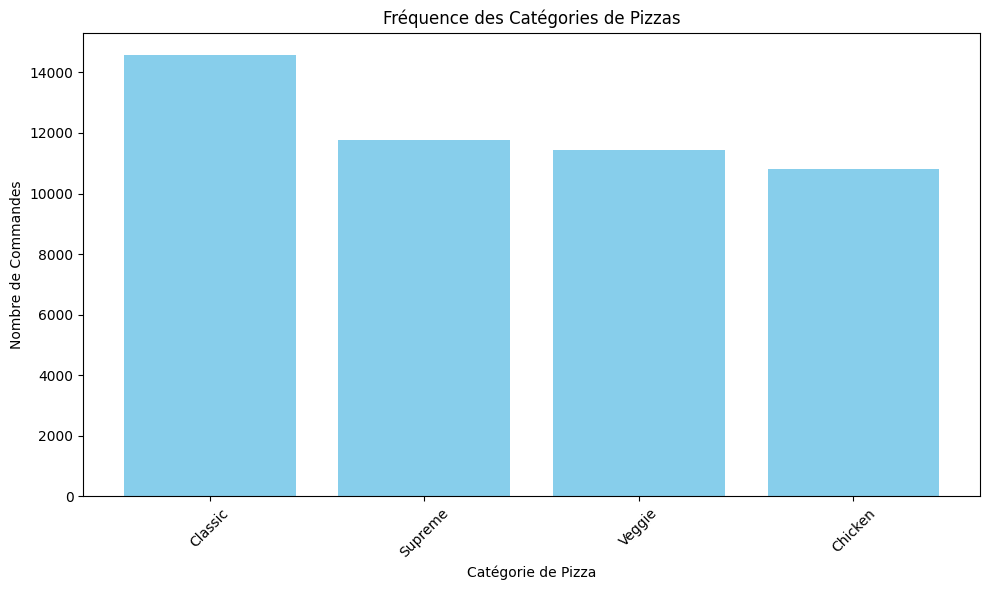

In [127]:
print('VISUALISATION : ')
most_pizza_category = df['pizza_category'].value_counts()
print(most_pizza_category)
print()
print()
most_pizza_category = most_pizza_category.idxmax()
print('La catégorie de pizza la plus fréquemment commandée  :', most_pizza_category)
print()

most_pizza_category_mode = df['pizza_category'].mode()
print('Catégorie de pizza la plus fréquemment commandée(s) :', most_pizza_category_mode)
print()
# Créer un graphique de barres empilées
category_counts = df['pizza_category'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts, color='skyblue')
plt.title('Fréquence des Catégories de Pizzas')
plt.xlabel('Catégorie de Pizza')
plt.ylabel('Nombre de Commandes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **5. Analyse des prix :**

a. Quel est le prix unitaire moyen des pizzas ?


In [125]:
prix_unit_moy = df['unit_price'].mean()
print('Prix unitaire moyen :', prix_unit_moy)
print()
prix_unit_moy2 = df['unit_price'].sum() / len(df['unit_price'])
print('Prix unitaire moyentest2 :', prix_unit_moy2)
print()
print("Colonnes 'unit_price' :", df['unit_price'].reset_index())

Prix unitaire moyen : 16.494132044426163

Prix unitaire moyentest2 : 16.494132044426163

Colonnes 'unit_price' :        index  unit_price
0          0       13.25
1          1       16.00
2          2       18.50
3          3       20.75
4          4       16.00
...      ...         ...
48615  48615       16.75
48616  48616       17.95
48617  48617       12.00
48618  48618       20.25
48619  48619       12.75

[48620 rows x 2 columns]


b. Quel est le prix total moyen d'une commande ?

In [89]:
prix_total_moyen_command = df['total_price'].mean()
prix_total_moyen_command
print(' prix total moyen dune commande :', prix_total_moyen_command)

prix_total_moyen_command2 = df['total_price'].sum() / len(df['order_id'])
print(' prix moyen dune commande en 2015 (méthode 2) :', prix_total_moyen_command2)

 prix total moyen dune commande : 16.821473673385437
 prix moyen dune commande en 2015 (méthode 2) : 16.821473673385437


c. Quelle pizza a le prix unitaire le plus élevé ?

In [90]:
pizza_price_unit_most_max = df.loc[df['unit_price'].idxmax(), 'pizza_name'] # j localise l'id de la valeur haute de unit_price puis je cherche le nom.
print('Pizza avec le prix unitaire le plus élevé :', pizza_price_unit_most_max)

pizza_max_price_name = df.nlargest(1, 'unit_price')['pizza_name'].iloc[0]
print('Pizza avec le prix unitaire le plus élevé (méthode 2) :', pizza_max_price_name)

max_price_value = df['unit_price'].max()
pizza_max_price_name = df[df['unit_price'] == max_price_value]['pizza_name'].iloc[0]
print('Pizza avec le prix unitaire le plus élevé (méthode 3) :', pizza_max_price_name)

pizza_max_price_name = df.sort_values(by='unit_price', ascending=False).iloc[0]['pizza_name']
print('Pizza avec le prix unitaire le plus élevé (méthode 4) :', pizza_max_price_name)

Pizza avec le prix unitaire le plus élevé : The Greek Pizza
Pizza avec le prix unitaire le plus élevé (méthode 2) : The Greek Pizza
Pizza avec le prix unitaire le plus élevé (méthode 3) : The Greek Pizza
Pizza avec le prix unitaire le plus élevé (méthode 4) : The Greek Pizza


## **6. Répartition par taille et catégorie :**

a. Combien de pizzas de chaque taille ont été vendues ?

La distribution des tailles de pizzas dans le jeu de données indique une forte demande pour les tailles L et M, suivies de près par la taille S. Il faut mettre l'accent sur la fabrication et la qualité des tailles L et M pour répondre à la demande majoritaire.

1. **Stratégie de Marketing Ciblé :** Mettre en œuvre des campagnes de marketing spécifiques pour les tailles XL et XXL, en identifiant des occasions spéciales et en collaborant avec des partenaires locaux pour accroître la visibilité.

2. **Diversification du Menu :** Proposer des saveurs exclusives, des offres groupées attractives et recueillir les commentaires des clients pour ajuster constamment le menu des tailles XL et XXL, stimulant ainsi l'intérêt et la demande.


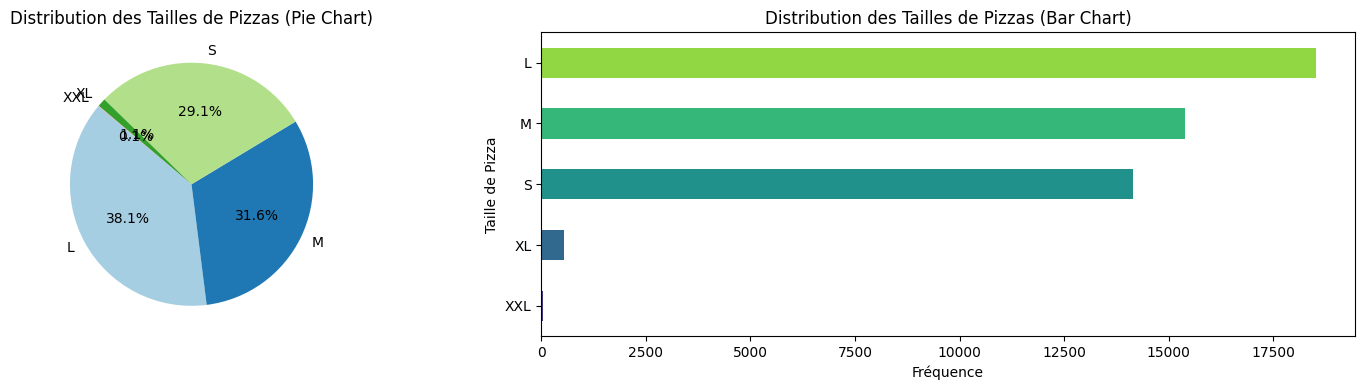

L      18526
M      15385
S      14137
XL       544
XXL       28
Name: pizza_size, dtype: int64

In [91]:
pizza_size_freq = df['pizza_size'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].pie(pizza_size_freq, labels=pizza_size_freq.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
axes[0].set_title('Distribution des Tailles de Pizzas (Pie Chart)')

viridis_palette = sns.color_palette("viridis", n_colors=len(pizza_size_freq))

pizza_size_freq.sort_values().plot(kind='barh', color=viridis_palette, ax=axes[1])
axes[1].set_title('Distribution des Tailles de Pizzas (Bar Chart)')
axes[1].set_xlabel('Fréquence')
axes[1].set_ylabel('Taille de Pizza')

plt.tight_layout()
plt.show()
pizza_size_freq

b. Combien de pizzas y a-t-il dans chaque catégorie ?

Dans la colonne 'pizza_category', il y a :

- 6 pizzas de la catégorie "Chicken"
- 8 pizzas de la catégorie "Classic"
- 9 pizzas de la catégorie "Supreme"
- 9 pizzas de la catégorie "Veggie"

En total, il y a 32 pizzas répertoriées dans le jeu de données.

pizza_category
Chicken    6
Classic    8
Supreme    9
Veggie     9
Name: pizza_name, dtype: int64



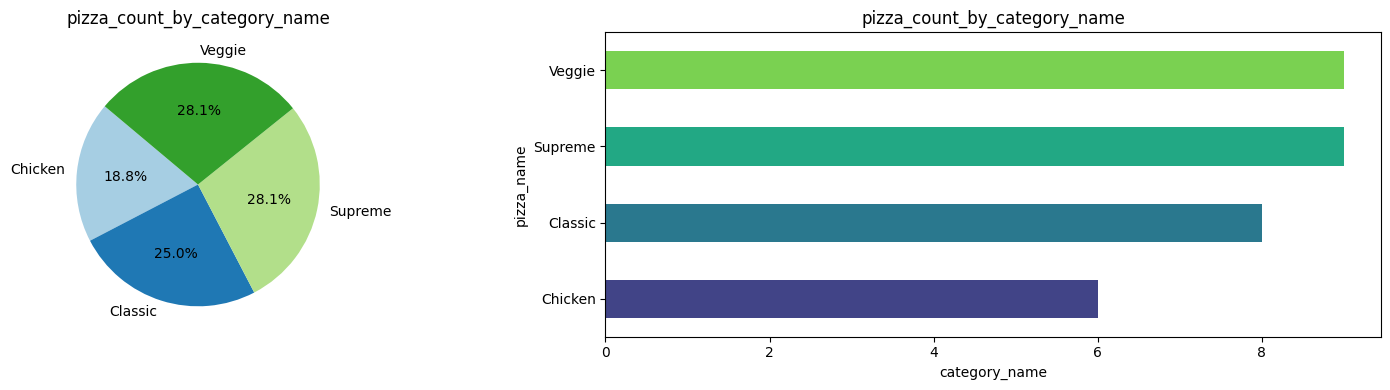


Il y a 32 pizzas répertoriées dans la colonne pizza_name.

['The Hawaiian Pizza' 'The Classic Deluxe Pizza' 'The Five Cheese Pizza'
 'The Italian Supreme Pizza' 'The Mexicana Pizza' 'The Thai Chicken Pizza'
 'The Prosciutto and Arugula Pizza' 'The Barbecue Chicken Pizza'
 'The Greek Pizza' 'The Spinach Supreme Pizza' 'The Green Garden Pizza'
 'The Italian Capocollo Pizza' 'The Spicy Italian Pizza'
 'The Spinach Pesto Pizza' 'The Vegetables + Vegetables Pizza'
 'The Southwest Chicken Pizza' 'The California Chicken Pizza'
 'The Pepperoni Pizza' 'The Chicken Pesto Pizza' 'The Big Meat Pizza'
 'The Soppressata Pizza' 'The Four Cheese Pizza' 'The Napolitana Pizza'
 'The Calabrese Pizza' 'The Italian Vegetables Pizza'
 'The Mediterranean Pizza' 'The Pepper Salami Pizza'
 'The Spinach and Feta Pizza' 'The Sicilian Pizza'
 'The Chicken Alfredo Pizza' 'The Pepperoni, Mushroom, and Peppers Pizza'
 'The Brie Carre Pizza']


In [92]:
pizza_count_by_category_name = df.groupby('pizza_category')['pizza_name'].nunique()
print(pizza_count_by_category_name)
print()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].pie(pizza_count_by_category_name, labels=pizza_count_by_category_name.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
axes[0].set_title('pizza_count_by_category_name')

viridis_palette = sns.color_palette("viridis", n_colors=len(pizza_count_by_category_name))

pizza_count_by_category_name.sort_values().plot(kind='barh', color=viridis_palette, ax=axes[1])
axes[1].set_title('pizza_count_by_category_name')
axes[1].set_xlabel('category_name')
axes[1].set_ylabel('pizza_name')

plt.tight_layout()
plt.show()

print()
Pizza_count_cat = df['pizza_name'].nunique()
print(f"Il y a {Pizza_count_cat} pizzas répertoriées dans la colonne pizza_name.")
print()
detail_name = df['pizza_name'].unique()
print(detail_name)

## **7. Anayse des ingrédients :**


a. Quels sont les ingrédients les plus couramment utilisés dans toutes les
pizzas ?

**str.split(', ')** sépare les ingrédients qui sont séparés par une virgule suivi d'un espace.

**explode()** transforme les listes d'ingrédients en une ligne par ingrédient.

**value_counts()** compte la fréquence de chaque ingrédient.

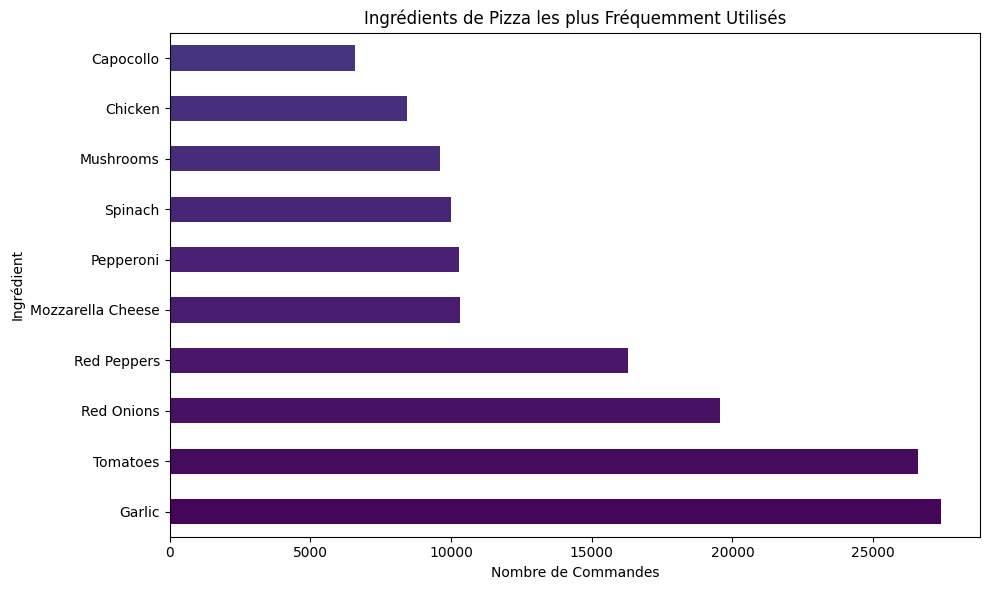

Garlic                27422
Tomatoes              26601
Red Onions            19547
Red Peppers           16284
Mozzarella Cheese     10333
                      ...  
Brie Carre Cheese       480
Prosciutto              480
Caramelized Onions      480
Pears                   480
Thyme                   480
Name: pizza_ingredients, Length: 65, dtype: int64

In [93]:

pizza_ingredients_most = df['pizza_ingredients'].str.split(', ').explode().value_counts()

# Utiliser la palette de couleurs viridis de seaborn
colors = sns.color_palette("viridis", len(pizza_ingredients_most))

plt.figure(figsize=(10, 6))
pizza_ingredients_most.head(10).sort_values(ascending=False).plot(kind='barh', color=colors)
plt.title('Ingrédients de Pizza les plus Fréquemment Utilisés')
plt.xlabel('Nombre de Commandes')
plt.ylabel('Ingrédient')
plt.tight_layout()
plt.show()

print()

pizza_ingredients_count = df['pizza_ingredients'].str.split(', ').explode().value_counts()
pizza_ingredients_count

b. Combien de pizzas contiennent un ingrédient spécifique (par exemple,
pepperoni, champignons) ?

Liste des noms uniques de pizzas contenant l'ingrédient pepperoni :
- The Classic Deluxe Pizza
- The Spinach Supreme Pizza
- The Pepperoni Pizza
- The Big Meat Pizza
- The Pepper Salami Pizza
- The Pepperoni, Mushroom, and Peppers Pizza


L'argument **case=False** dans la méthode str.contains() indique que la recherche de l'ingrédient spécifique dans la colonne 'pizza_ingredients' doit être insensible à la casse. Cela signifie que la recherche ne fera pas de distinction entre majuscules et minuscules.

In [94]:
ingredient_specifique3 = 'pepperoni'

pizzas_contenant_ingredient3 = df[df['pizza_ingredients'].str.contains(ingredient_specifique3, case=False)]

noms_uniques_pizzas_contenant_ingredient3 = pizzas_contenant_ingredient3['pizza_name'].unique()

if len(noms_uniques_pizzas_contenant_ingredient3) > 0:
    print(f"Liste des noms uniques de pizzas contenant l'ingrédient {ingredient_specifique3} :")
    for nom_pizza in noms_uniques_pizzas_contenant_ingredient3:
        print(f"- {nom_pizza}")
else:
    print(f"Aucune pizza ne contient l'ingrédient {ingredient_specifique3}.")

print()
print()


ingredient_specifique = 'pepperoni'

nombre_pizzas_contenant_ingredient = df['pizza_ingredients'].str.contains(ingredient_specifique, case=False).sum()

print(f"Le nombre de pizzas contenant l'ingrédient {ingredient_specifique} est : {nombre_pizzas_contenant_ingredient}")
print()
print()

ingredient_specifique2 = 'Garlic'

nombre_pizzas_contenant_ingredient2 = df['pizza_ingredients'].str.contains(ingredient_specifique2, case=False).sum()
print(f"Le nombre de pizzas contenant l'ingrédient 2 {ingredient_specifique2} est : {nombre_pizzas_contenant_ingredient2}")

print()
print()

print('METHODE PLUS LONGUE EN 2 ETAPES:')

ingredient_specifique3 = 'pepperoni'

pizzas_contenant_ingredient3 = df[df['pizza_ingredients'].str.contains(ingredient_specifique3, case=False)]
nombre_pizzas_contenant_ingredient3 = len(pizzas_contenant_ingredient3)

print(f"Le nombre de pizzas contenant l'ingrédient {ingredient_specifique3} est : {nombre_pizzas_contenant_ingredient3}")

Liste des noms uniques de pizzas contenant l'ingrédient pepperoni :
- The Classic Deluxe Pizza
- The Spinach Supreme Pizza
- The Pepperoni Pizza
- The Big Meat Pizza
- The Pepper Salami Pizza
- The Pepperoni, Mushroom, and Peppers Pizza


Le nombre de pizzas contenant l'ingrédient pepperoni est : 10300


Le nombre de pizzas contenant l'ingrédient 2 Garlic est : 27422


METHODE PLUS LONGUE EN 2 ETAPES:
Le nombre de pizzas contenant l'ingrédient pepperoni est : 10300


## **8. Détails de la commande :**

a. Quelle est la répartition du nombre de pizzas par commande ?

REPARTITION PAR QUANTITE : Combien de commandes contiennent X Pizza
    Qty Pizzas  Nbr Commandes
0            1           8111
1            2           6152
2            3           3207
3            4           3122
4            5            145
5            6             80
6            8             67
7           14             66
8            9             64
9            7             61
10          15             57
11          10             56
12          11             56
13          12             54
14          13             50
15          25              1
16          28              1


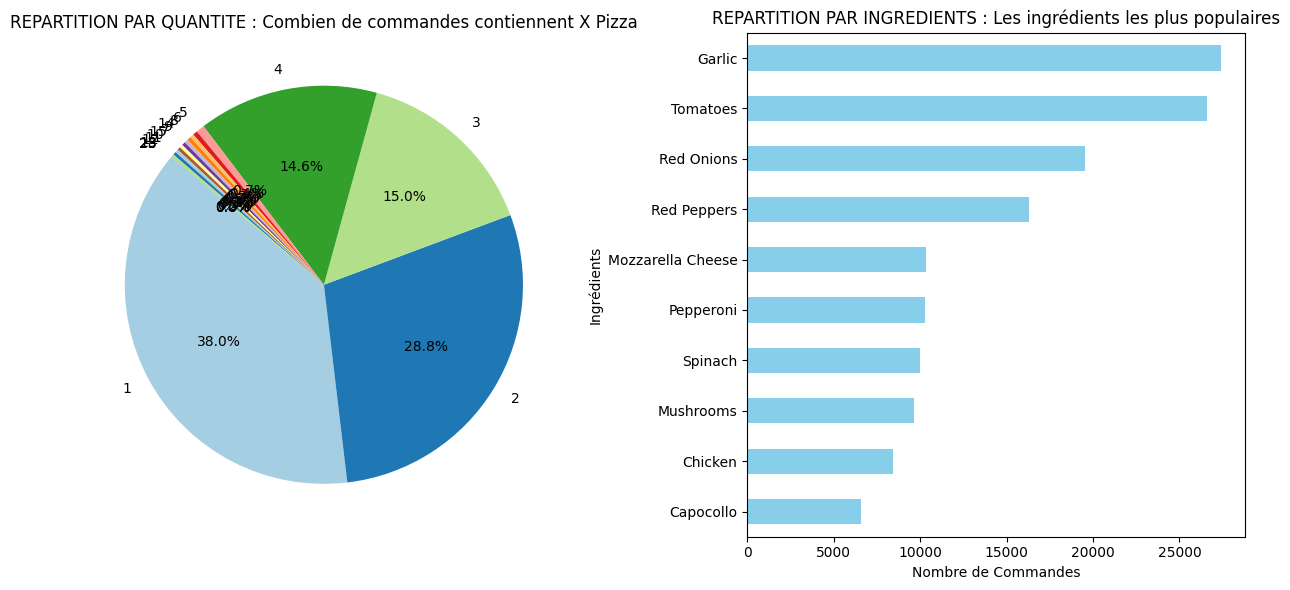

In [95]:
import matplotlib.pyplot as plt

# Repartition par quantité : Combien de commandes contiennent X Pizza
repartition_by_quantity = df.groupby('order_id')['quantity'].sum().value_counts().reset_index()
repartition_by_quantity.columns = ['Qty Pizzas', 'Nbr Commandes']

print('REPARTITION PAR QUANTITE : Combien de commandes contiennent X Pizza')
print(repartition_by_quantity)

# Nombre de pizzas par commande
nbr_pizza_by_command = df.groupby('order_id')['quantity'].sum()

# Tracer les graphiques
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(nbr_pizza_by_command.value_counts(), labels=nbr_pizza_by_command.value_counts().index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('REPARTITION PAR QUANTITE : Combien de commandes contiennent X Pizza')

plt.subplot(1, 2, 2)
repartition_by_ingredients = df['pizza_ingredients'].str.split(', ').explode().value_counts()
repartition_by_ingredients.head(10).sort_values().plot(kind='barh', color='skyblue')
plt.title('REPARTITION PAR INGREDIENTS : Les ingrédients les plus populaires')
plt.xlabel('Nombre de Commandes')
plt.ylabel('Ingrédients')

plt.tight_layout()
plt.show()

In [96]:
repartition_by_quantity = df.groupby('order_id')['quantity'].sum().value_counts().reset_index()
repartition_by_quantity.columns = ['Qty Pizzas', 'Nbr Commandes']
print('REPARTITION PAR QUANTITE : Combien de commandes contiennent X Pizza')
print( repartition_by_quantity)

nombre_de_commandes_uniques = len(df['order_id'].unique())
print('Nombre total de commandes uniques :', nombre_de_commandes_uniques)
print()
print()

nbr_pizza_by_command = df.groupby('order_id')['quantity'].sum()
print('NOMBRE DE PIZZA PAR COMMANDE:', nbr_pizza_by_command)
print()
print()

repartition_pourcentage = (nbr_pizza_by_command / nombre_de_commandes_uniques)*100
print('REPARTITION EN POURCENTAGE :', repartition_pourcentage)

REPARTITION PAR QUANTITE : Combien de commandes contiennent X Pizza
    Qty Pizzas  Nbr Commandes
0            1           8111
1            2           6152
2            3           3207
3            4           3122
4            5            145
5            6             80
6            8             67
7           14             66
8            9             64
9            7             61
10          15             57
11          10             56
12          11             56
13          12             54
14          13             50
15          25              1
16          28              1
Nombre total de commandes uniques : 21350


NOMBRE DE PIZZA PAR COMMANDE: order_id
1        1
2        5
3        2
4        1
5        1
        ..
21346    4
21347    4
21348    3
21349    1
21350    1
Name: quantity, Length: 21350, dtype: int64


REPARTITION EN POURCENTAGE : order_id
1        0.004684
2        0.023419
3        0.009368
4        0.004684
5        0.004684
           ...

b. Quelle est la répartition des prix totaux pour les commandes ?

A QUELLES REPARTTION DES PRIX TOTAUX - COLONNES total_price/total_price
----------------DECOUVERTE----descriptive-------
LE CA ANNUEL 2015 EST : 817860.05


PRIX TOTAL PAR COMMANDE :
       Num Commande  Px Total by order
0                 1              13.25
1                 2              92.00
2                 3              37.25
3                 4              16.50
4                 5              16.50
...             ...                ...
21345         21346              62.25
21346         21347              66.50
21347         21348              46.70
21348         21349              20.25
21349         21350              12.75

[21350 rows x 2 columns]

"RÉSUMÉ DES STATISTIQUES DESCRIPTIVES"
       Num Commande  Px Total by order
count      21350.00           21350.00
mean       10675.50              38.31
std         6163.36              30.65
min            1.00               9.75
25%         5338.25              17.95
50%        10675.50              32.50
75%       

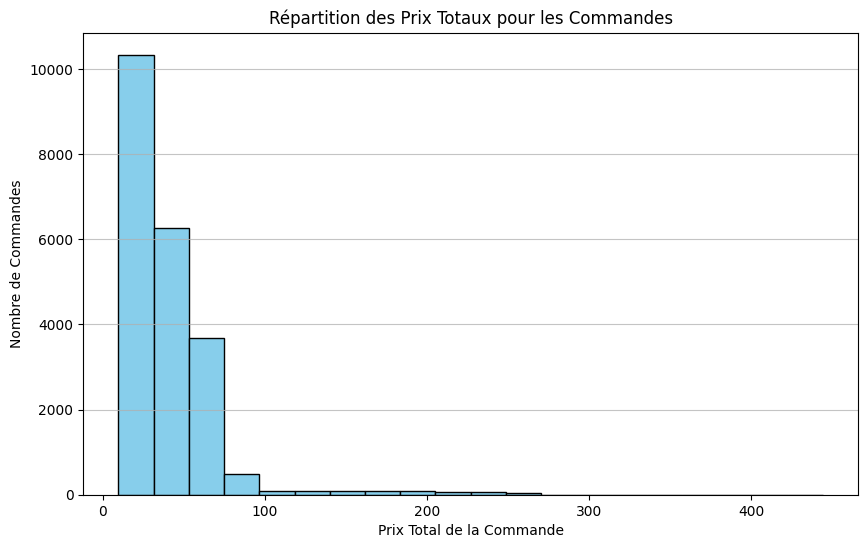

In [97]:
print('A QUELLES REPARTTION DES PRIX TOTAUX - COLONNES total_price/total_price')

print('----------------DECOUVERTE----descriptive-------')
px_total_all_command = df['total_price'].sum()
print('LE CA ANNUEL 2015 EST :',px_total_all_command)
print()
print()

px_totaux_by_command = df.groupby('order_id')['total_price'].sum().reset_index()
px_totaux_by_command.columns = ['Num Commande', 'Px Total by order']
df2 = px_totaux_by_command
print('PRIX TOTAL PAR COMMANDE :')
print(df2)
print()

print('"RÉSUMÉ DES STATISTIQUES DESCRIPTIVES"')
describe = df2.describe().round(2)
print(describe)
print()
print()

print('repartition en % :')
df2['Pourcentage_par_command'] = (df2['Px Total by order'] / px_total_all_command) * 100
print(df2)
print()
print()

repartition_order_by_total = px_totaux_by_command['Px Total by order'].value_counts().reset_index()
repartition_order_by_total.columns = ['Somme Totale par Commande', 'Nbr Commandes']

#mise en forme ascending
repartition_order_by_total = repartition_order_by_total.sort_values(by='Somme Totale par Commande', ascending=True)
print('REPARTITION PAR TOTAL DES ORDERS: Combien de commandes ont une somme totale de X')
print(repartition_order_by_total)

df['total_price'] = df['unit_price'] * df['quantity']

plt.figure(figsize=(10, 6))
plt.hist(df.groupby('order_id')['total_price'].sum(), bins=20, color='skyblue', edgecolor='black')
plt.title('Répartition des Prix Totaux pour les Commandes')
plt.xlabel('Prix Total de la Commande')
plt.ylabel('Nombre de Commandes')
plt.grid(axis='y', alpha=0.75)
plt.show()

### **9. Analyse du chiffre d’affaires en fonction du temps :**

a. Quel est le chiffre d'affaires quotidien ?

Liste du Ca Quot. 2015 :
order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
               ...   
2015-12-27    1419.00
2015-12-28    1637.20
2015-12-29    1353.25
2015-12-30    1337.80
2015-12-31    2916.00
Name: total_price, Length: 358, dtype: float64


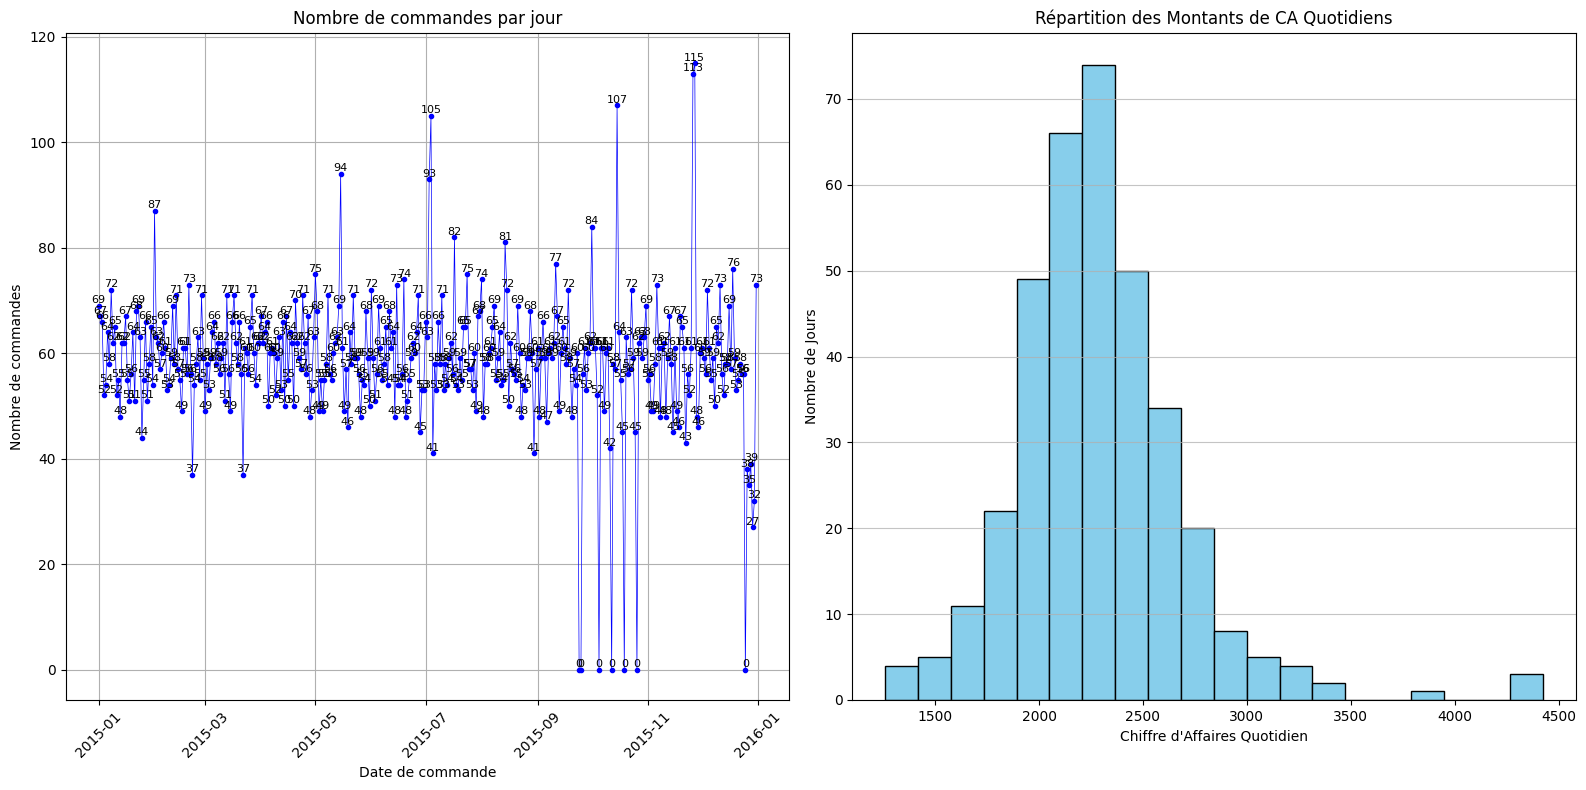

In [98]:
df['order_date'] = pd.to_datetime(df['order_date'])
CA_quotidien = df.groupby(df['order_date'])['total_price'].sum()
print('Liste du Ca Quot. 2015 :')
print(CA_quotidien)

# Renommer
CA_quotidien = CA_quotidien.reset_index()  # 'order_date' en tant que colonne
CA_quotidien = CA_quotidien.rename(columns={'order_date': 'Date', 'total_price': 'CA_quotidien'})

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(merged_df['order_date'], merged_df['order_id'], marker='.', linestyle='-', color='b', linewidth=0.5)
plt.title('Nombre de commandes par jour')
plt.xlabel('Date de commande')
plt.ylabel('Nombre de commandes')
plt.xticks(rotation=45)  # Pivoter les étiquettes des jours
plt.grid(True)

# Ajouter les chiffres sur le plot
for date, orders in zip(merged_df['order_date'], merged_df['order_id']):
    plt.text(date, orders + 0.1, str(int(orders)), ha='center', va='bottom', fontsize=8)

plt.subplot(1, 2, 2)
plt.hist(CA_quotidien['CA_quotidien'], bins=20, color='skyblue', edgecolor='black')
plt.title('Répartition des Montants de CA Quotidiens')
plt.xlabel('Chiffre d\'Affaires Quotidien')
plt.ylabel('Nombre de Jours')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

b. Y a-t-il une corrélation entre l'heure de la journée et le total de la
commande ?

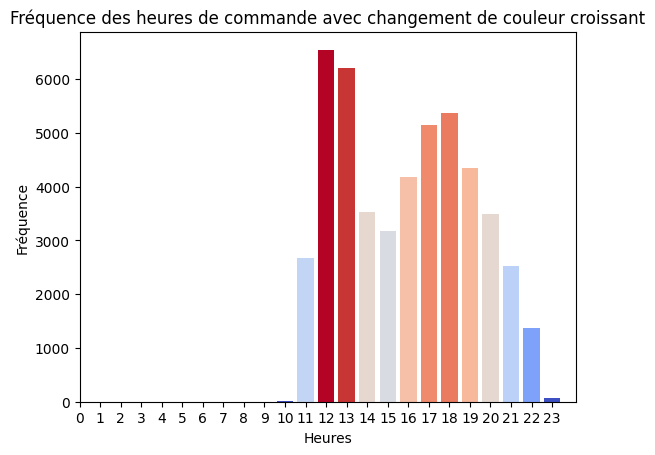

In [99]:
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S')

frequence_hours = df['order_time'].dt.hour.value_counts().sort_index(ascending=True)

normalized_values = (frequence_hours - frequence_hours.min()) / (frequence_hours.max() - frequence_hours.min())

# Exclure les heures avec une fréquence nulle
frequence_hours = frequence_hours[frequence_hours != 0]

colors = plt.cm.coolwarm(normalized_values)  # Utiliser la colormap coolwarm
plt.bar(frequence_hours.index, frequence_hours.values, color=colors)

plt.xlabel('Heures')
plt.ylabel('Fréquence')
plt.title('Fréquence des heures de commande avec changement de couleur croissant')

plt.xticks(range(24))  # Utiliser toutes les heures distinctes sur l'axe x
plt.show()

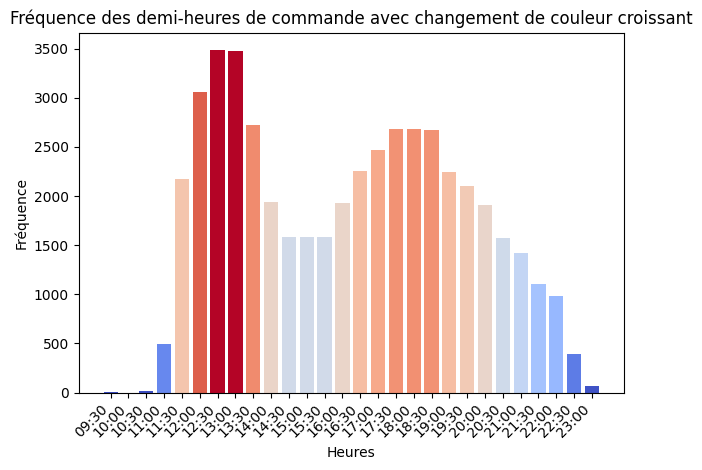

In [100]:
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S')

df['rounded_order_time'] = df['order_time'].dt.floor('30min')

# Extraire les heures arrondies
frequence_half_hours = df['rounded_order_time'].dt.time.value_counts().sort_index(ascending=True)

# Formater les étiquettes de l'axe x pour exclure les secondes
formatted_labels = [time.strftime('%H:%M') for time in frequence_half_hours.index]

# Normaliser les valeurs de fréquence entre 0 et 1
normalized_values = (frequence_half_hours - frequence_half_hours.min()) / (frequence_half_hours.max() - frequence_half_hours.min())

colors = plt.cm.coolwarm(normalized_values)  # Utiliser la colormap coolwarm
plt.bar(formatted_labels, frequence_half_hours.values, color=colors)

plt.xlabel('Heures')
plt.ylabel('Fréquence')
plt.title('Fréquence des demi-heures de commande avec changement de couleur croissant')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [101]:
###test nova test de correlation
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S')
df['order_time'] = df['order_time'].dt.round('H')
ca_heure = df.groupby(df['order_time'])['total_price'].sum()

print()
print('STATS CA / HEURE')
print(ca_heure.describe().round(2))
print()

ca_heure.index = ca_heure.index.strftime('%H:%M') + ' ' + (ca_heure.index + pd.Timedelta(hours=1)).strftime('%H:%M')
ca_heure.index.name = 'Tranche Horraire'
print(ca_heure.reset_index())


STATS CA / HEURE
count        14.00
mean      58418.58
std       35315.21
min          95.50
25%       38669.19
50%       62834.55
75%       81602.46
max      119073.35
Name: total_price, dtype: float64

   Tranche Horraire  total_price
0       10:00 11:00        95.50
1       11:00 12:00      8693.15
2       12:00 13:00     88701.30
3       13:00 14:00    119073.35
4       14:00 15:00     79519.75
5       15:00 16:00     52980.40
6       16:00 17:00     58620.70
7       17:00 18:00     79000.75
8       18:00 19:00     89653.30
9       19:00 20:00     82296.70
10      20:00 21:00     67048.40
11      21:00 22:00     49776.35
12      22:00 23:00     34966.80
13      23:00 00:00      7433.60


### **10.Pizzas populaires :**

a. Quelles sont les 5 pizzas les plus commandées en quantité ?

NOM DES PIZZAS DES 5 PLUS GRANDS CA:

The Thai Chicken Pizza  43434.25

The Barbecue Chicken Pizza  42768.00

The California Chicken Pizza  41409.50

The Classic Deluxe Pizza  38180.50

The Spicy Italian Pizza  34831.25

NOM DES PIZZAS DES 5 PLUS GRANDS CA:
                     pizza_name   CA 2015
0        The Thai Chicken Pizza  43434.25
1    The Barbecue Chicken Pizza  42768.00
2  The California Chicken Pizza  41409.50
3      The Classic Deluxe Pizza  38180.50
4       The Spicy Italian Pizza  34831.25

DETAILS DES COMMANDES DES 5 PIZZAS AVEC LES PLUS GRANDS CA:
                         pizza_name  total_price order_date  quantity
0          The Classic Deluxe Pizza        16.00 2015-01-01         1
1          The Classic Deluxe Pizza        12.00 2015-01-01         1
2          The Classic Deluxe Pizza        12.00 2015-01-01         1
3          The Classic Deluxe Pizza        16.00 2015-01-01         1
4          The Classic Deluxe Pizza        16.00 2015-01-01         1
...                             ...          ...        ...       ...
11287  The California Chicken Pizza        12.75 2015-12-31         1
11288  The California Chicken Pizza        20.75 2015-12-31         1
11289  The Californi

<ipython-input-102-8e95b67f7701>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pizza_name', y='CA 2015', data=top_5_pizzas, palette=rose_palette)


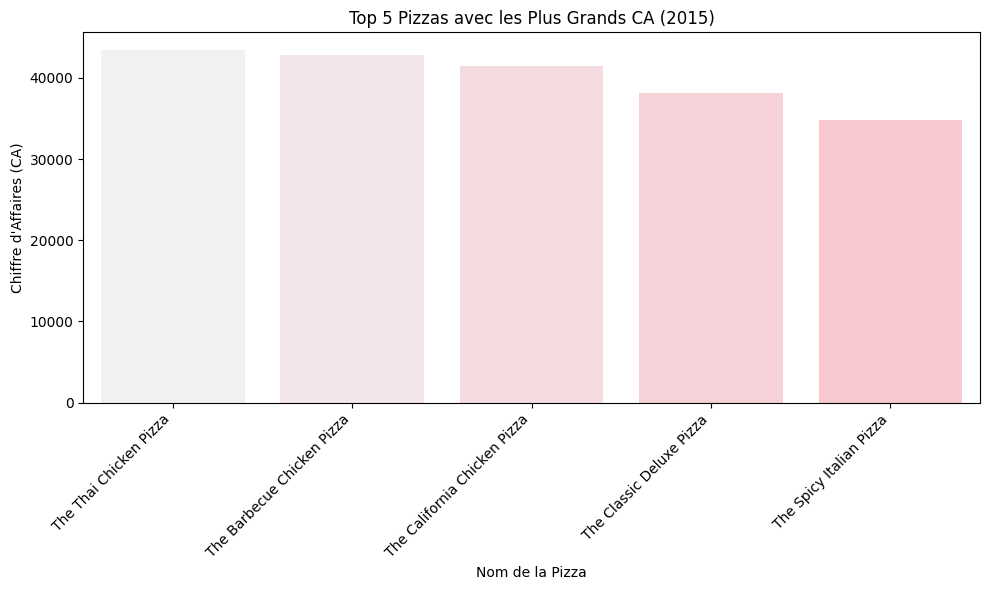


PROPORTIONS DES TAILLES POUR LES 5 PIZZAS AVEC LES PLUS GRANDS CA:
pizza_size                           L         M         S
pizza_name                                                
The Barbecue Chicken Pizza    0.407673  0.390388  0.201939
The California Chicken Pizza  0.388792  0.397046  0.214162
The Classic Deluxe Pizza      0.194950  0.479719  0.325331
The Spicy Italian Pizza       0.576577  0.211977  0.211447
The Thai Chicken Pizza        0.589633  0.204752  0.205616

PROPORTIONS DES TAILLES POUR LES 5 PIZZAS AVEC LES PLUS GRANDS CA:
pizza_size                           L         M         S
pizza_name                                                
The Barbecue Chicken Pizza    0.407673  0.390388  0.201939
The California Chicken Pizza  0.388792  0.397046  0.214162
The Classic Deluxe Pizza      0.194950  0.479719  0.325331
The Spicy Italian Pizza       0.576577  0.211977  0.211447
The Thai Chicken Pizza        0.589633  0.204752  0.205616


In [102]:
top_5_pizzas = df.groupby('pizza_name')['total_price'].sum().nlargest(5).reset_index(name='CA 2015')

# Fusionner avec le DataFrame original pour obtenir les noms des pizzas
merged_top_5_pizzas = pd.merge(df, top_5_pizzas, on='pizza_name', how='inner')

print('NOM DES PIZZAS DES 5 PLUS GRANDS CA:')
print(top_5_pizzas[['pizza_name', 'CA 2015']])

print('\nDETAILS DES COMMANDES DES 5 PIZZAS AVEC LES PLUS GRANDS CA:')
print(merged_top_5_pizzas[['pizza_name', 'total_price', 'order_date', 'quantity']])

rose_palette = sns.light_palette("pink", n_colors=5)

plt.figure(figsize=(10, 6))
sns.barplot(x='pizza_name', y='CA 2015', data=top_5_pizzas, palette=rose_palette)
plt.title('Top 5 Pizzas avec les Plus Grands CA (2015)')
plt.xlabel('Nom de la Pizza')
plt.ylabel('Chiffre d\'Affaires (CA)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Table croisée des proportions des tailles pour les pizzas du top 5
size_proportions = pd.crosstab(merged_top_5_pizzas['pizza_name'], merged_top_5_pizzas['pizza_size'], normalize='index')

print('\nPROPORTIONS DES TAILLES POUR LES 5 PIZZAS AVEC LES PLUS GRANDS CA:')
print(size_proportions)

# Créer une table croisée des proportions des tailles pour les pizzas du top 5
size_proportions = pd.crosstab(merged_top_5_pizzas['pizza_name'], merged_top_5_pizzas['pizza_size'], normalize='index')

print('\nPROPORTIONS DES TAILLES POUR LES 5 PIZZAS AVEC LES PLUS GRANDS CA:')
print(size_proportions)

b. Quelles sont les 5 pizzas les plus commandées en termes de chiffre
d'affaires ?

In [103]:
top_5_CA_pizzas = df['pizza_name'].value_counts().head(5).reset_index().rename(columns={'index': 'PIZZA NAME', 'pizza_name': 'CA 2015'})
print(top_5_CA_pizzas)

                   PIZZA NAME  CA 2015
0    The Classic Deluxe Pizza     2416
1  The Barbecue Chicken Pizza     2372
2          The Hawaiian Pizza     2370
3         The Pepperoni Pizza     2369
4      The Thai Chicken Pizza     2315


### **11.Chiffre d'affaires par taille et catégorie :**

a. Quelle est la répartition du chiffre d'affaires pour chaque taille de pizza ?

In [104]:
ca_tt = df['total_price'].sum()
print('LA SOMME TOTA DU CA 2015 EST :', ca_tt)

print()
repartition_ca_size = df.groupby('pizza_size')['total_price'].sum().reset_index(name='CA 2015')
print('--------REPARTITION EN CA 2015 PAR TAILLE DES PIZZA : ----')
print(repartition_ca_size)

print()

Sum_Ca_2015 = (df.groupby('pizza_size')['total_price'].sum() / df['total_price'].sum()) * 100
Sum_Ca_2015 = Sum_Ca_2015.reset_index(name='%')
print('------REPARTITION % DE CA 2015 PAR TAILLE DES PIZZA :------ ')
print(Sum_Ca_2015)

LA SOMME TOTA DU CA 2015 EST : 817860.05

--------REPARTITION EN CA 2015 PAR TAILLE DES PIZZA : ----
  pizza_size    CA 2015
0          L  375318.70
1          M  249382.25
2          S  178076.50
3         XL   14076.00
4        XXL    1006.60

------REPARTITION % DE CA 2015 PAR TAILLE DES PIZZA :------ 
  pizza_size          %
0          L  45.890333
1          M  30.492044
2          S  21.773468
3         XL   1.721077
4        XXL   0.123077


**b. Quelle est la répartition du chiffre d'affaires pour chaque catégorie depizza ?**


On observe que la catégorie "Classic" a la part la plus élevée tant en termes de chiffre d'affaires total que de pourcentage. "Chicken" et "Supreme" sont également des contributeurs significatifs, tandis que "Veggie" a la part la plus basse.

**AXES D'AMELIORATIONS :**

1. **Promotion ciblée sur la catégorie "Classic":**
   Compte tenu de sa part élevée tant en termes de chiffre d'affaires total que de pourcentage, une décision commerciale pourrait consister à lancer des promotions spéciales, des offres groupées ou des réductions sur les pizzas de la catégorie "Classic". Cela pourrait stimuler davantage les ventes dans cette catégorie et fidéliser les clients qui ont montré une préférence pour ce type de pizza.

2. **Développement de nouvelles pizzas dans la catégorie "Chicken" et "Supreme":**
   Étant donné que les catégories "Chicken" et "Supreme" contribuent significativement au chiffre d'affaires, une stratégie de développement de produits pourrait consister à introduire de nouvelles variétés de pizzas ou des éditions limitées dans ces catégories. Cela pourrait attirer l'attention des clients existants et en attirer de nouveaux, diversifiant ainsi l'offre et augmentant les ventes dans ces segments.

3. **Campagne de marketing axée sur la catégorie "Veggie":**
   Bien que la catégorie "Veggie" ait la part la plus basse, elle représente toujours une part significative du chiffre d'affaires global. Une décision marketing pourrait consister à lancer une campagne spécifique mettant en avant les avantages santé, la variété des ingrédients végétariens, et promouvant la catégorie "Veggie" comme une option saine et délicieuse. Cela pourrait attirer l'attention des consommateurs soucieux de leur santé et augmenter la demande pour les pizzas végétariennes.

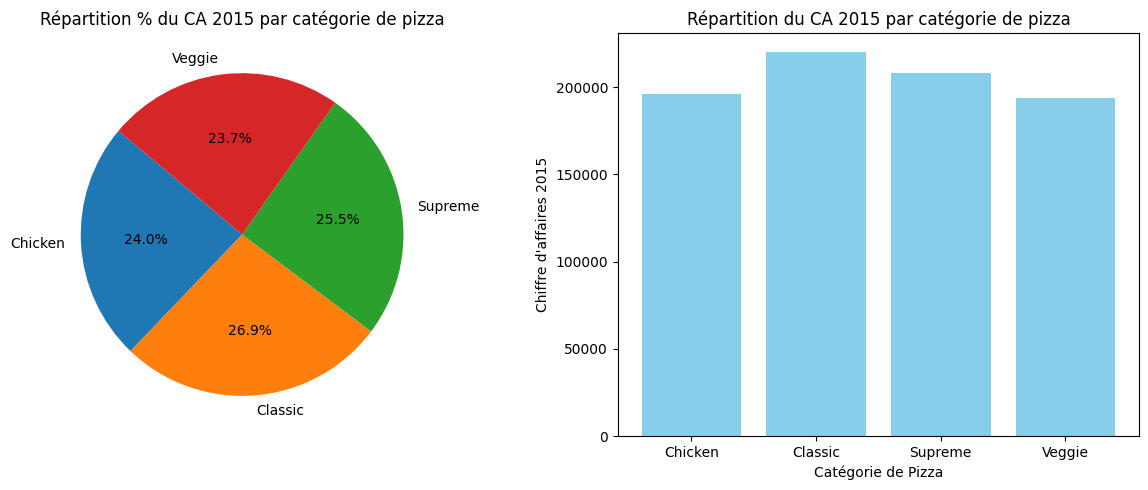

In [105]:
repartition_ca_category = df.groupby('pizza_category')['total_price'].sum().reset_index(name='CA 2015 par catégorie')

Sum_Ca_Category = (df.groupby('pizza_category')['total_price'].sum() / df['total_price'].sum()) * 100
Sum_Ca_Category = Sum_Ca_Category.reset_index(name='%')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(Sum_Ca_Category['%'], labels=Sum_Ca_Category['pizza_category'], autopct='%1.1f%%', startangle=140)
plt.title('Répartition % du CA 2015 par catégorie de pizza')

plt.subplot(1, 2, 2)
plt.bar(repartition_ca_category['pizza_category'], repartition_ca_category['CA 2015 par catégorie'], color='skyblue')
plt.xlabel('Catégorie de Pizza')
plt.ylabel('Chiffre d\'affaires 2015')
plt.title('Répartition du CA 2015 par catégorie de pizza')

plt.tight_layout()

plt.show()

### **12.Corrélation entre prix et quantité :**


**a. Y a-t-il une corrélation entre le prix unitaire et la quantité commandée ?**

J'ai appliqué 3 méthodes de correlations :

Pearson : 0.007142463924669923,

Spearman : 0.009722748837510061,

Kendall : 0.00825610582820451


Il y a une corrélation très faible entre le prix unitaire et la quantité commandée : Aucune tendance claire dans un premier temps.
Même si la corrélation linéaire soit faible, ca ne veut pas dire qu'il n'y a pas d'autres relations complexes.

**Je propose d'effectuer des analyses plus approfondies, par exemple une correlation sur les groupes les plus polpulaires**

On peut tout de même s'appercevoir à vu qu'il existe un **group homogène d'un CA à 4 chiffres entre 16€ et 20,75€**  voir : VISUALISATION PRIX DECROISSANTS/QUANTITES.

VISUALISATION PRIX DECROISSANTS/QUANTITES : analyse visuelle peut être subjective : Une tendance pourrait être que des **prix unitaires modérés à moyens (compris entre 12 et 18 euros environ)** sont associés à des quantités importantes.

**AVEC LE NUAGE DE POINTS : On peut observer une corrélation avec une *"densité plus forte de commandes"* couplées à *"l'augmentation du nombre de pizza par commande"* sur les tranches de prix suivants : 12€-13€ .... 16€-17€  ....  20€-21€**

**VISUALISATION PRIX DECROISSANTS / QUANTITES :**
On observe un agrégat de chiffre d'affaires à quatre chiffres entre 16€ et 20,75€, avec une forte anomalie à 17€,50. Cela corrobore l'analyse du "Nuage de Points".

**Avec le test de ANOVA :**
Il y a une variation statistiquement significative qui suggère que les niveaux de prix ont un impact sur la quantité commandée. Cela pourrait indiquer que certains prix ont tendance à être associés à des quantités plus élevées, tandis que d'autres prix sont associés à des quantités plus faibles.

**Avec le test TUkey : ** l n'y a pas de différence significative entre les moyennes de ces groupes. Cependant, il y a quelques cas où l'hypothèse nulle est rejetée (indiqué par "True"). Il y a donc sur **certains prix **une corrélation.

AXES D'AMELIORATIONS :
**texte en gras**

1. **Promotion ciblée sur les tranches de prix modérées (12-18 euros) :**
   Encourager les ventes en offrant des remises ou des offres spéciales sur les pizzas dans cette fourchette de prix, en raison de la corrélation avec des quantités importantes.

2. **Lancement de pizzas premium dans la fourchette de prix élevés (16-20,75 euros) :**
   Développer des options haut de gamme pour capturer le groupe homogène d'un chiffre d'affaires élevé dans cette gamme, offrant des produits exclusifs pour une clientèle prête à dépenser plus.

3. **Campagne marketing mettant en avant la diversité des commandes :**
   Axer la campagne sur la variété des commandes, en soulignant que certaines tranches de prix spécifiques sont associées à une plus grande diversité de pizzas par commande. Offrir des promotions spéciales pour encourager les clients à découvrir une sélection diversifiée de saveurs.

TROIS METHODES DE CORRELATION
Coefficient de corrélation de Pearson : 0.007142463924669923
Coefficient de corrélation de Spearman : 0.009722748837510061
Coefficient de corrélation de Kendall : 0.008256105828204517

------ESSAIE DE DEGAGER UNE CORRELATION EN FAISANT DES MOYENNES VOIR TEBLEAU 1 ET 2 : CORRELATION PROCHE DE ZERO - aucune fluctuations----------------------



<ipython-input-106-e9b950ceb062>:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


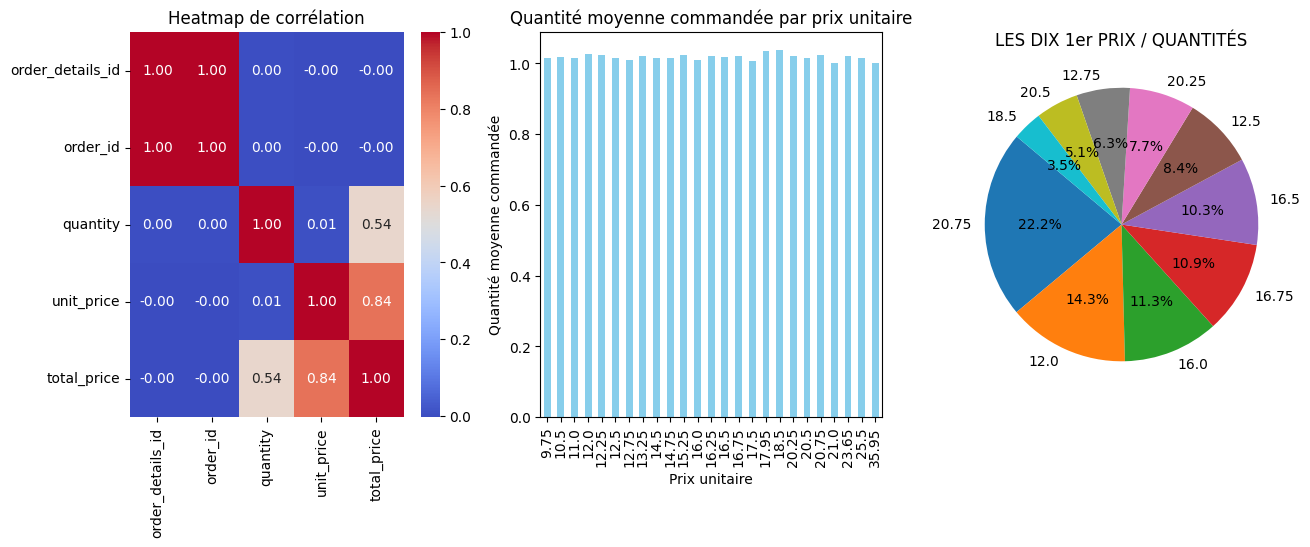

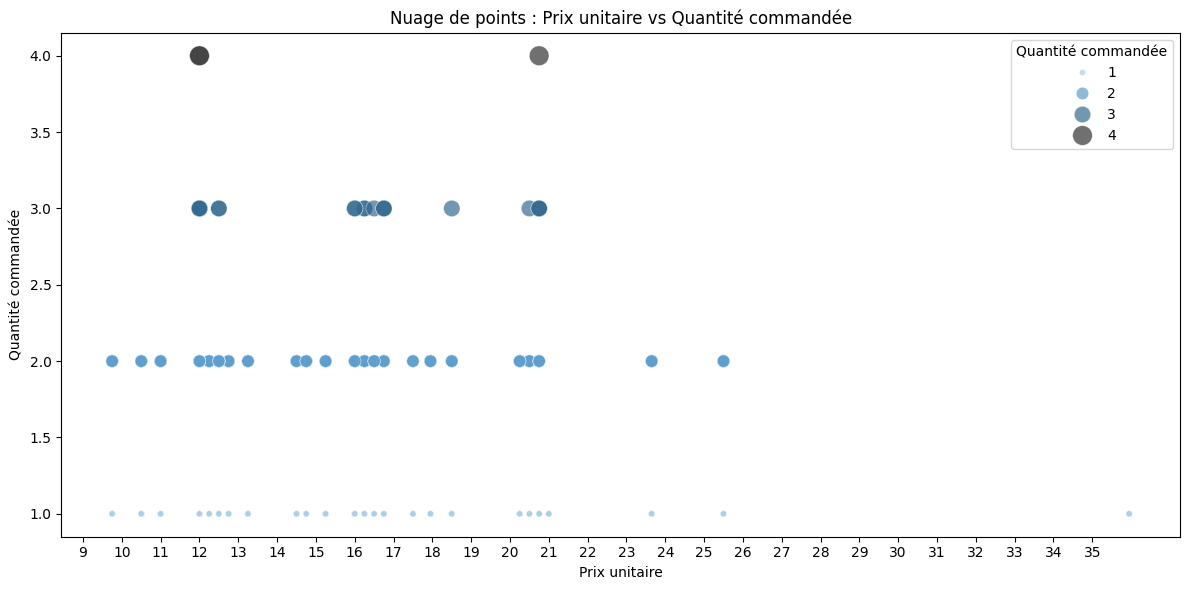



VISUALISATION PRIX DECROISSANTS/QUANTITES
    unit_price  quantity
0         9.75       751
1        10.50      1020
2        11.00       578
3        12.00      5744
4        12.25       850
5        12.50      3380
6        12.75      2529
7        13.25       483
8        14.50       397
9        14.75       586
10       15.25       728
11       16.00      4522
12       16.25      1136
13       16.50      4111
14       16.75      4380
15       17.50       384
16       17.95      1316
17       18.50      1409
18       20.25      3093
19       20.50      2026
20       20.75      8891
21       21.00       190
22       23.65       490
23       25.50       552
24       35.95        28

DESCRIBE DE :
       unit_price  quantity
count       25.00     25.00
mean        17.02   1982.96
std          5.70   2154.71
min          9.75     28.00
25%         12.75    552.00
50%         16.25   1020.00
75%         20.25   3093.00
max         35.95   8891.00

VISUALISATION PRIX /QUANTITES DECROISS

In [106]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print('TROIS METHODES DE CORRELATION')

correlation_pearson = df['unit_price'].corr(df['quantity'])
print("Coefficient de corrélation de Pearson :", correlation_pearson)

correlation_spearman = df['unit_price'].corr(df['quantity'], method='spearman')
print("Coefficient de corrélation de Spearman :", correlation_spearman)

correlation_kendall = df['unit_price'].corr(df['quantity'], method='kendall')
print("Coefficient de corrélation de Kendall :", correlation_kendall)

print()
print('------ESSAIE DE DEGAGER UNE CORRELATION EN FAISANT DES MOYENNES VOIR TEBLEAU 1 ET 2 : CORRELATION PROCHE DE ZERO - aucune fluctuations----------------------')
print()
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Heatmap
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title('Heatmap de corrélation')

# Barplot
average_quantity_per_price = df.groupby('unit_price')['quantity'].mean()
average_quantity_per_price.plot(kind='bar', color='skyblue', ax=axes[1])
axes[1].set_xlabel('Prix unitaire')
axes[1].set_ylabel('Quantité moyenne commandée')
axes[1].set_title('Quantité moyenne commandée par prix unitaire')

#  Pie chart
visu_price_quant = df.groupby('unit_price')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)
top_prices = visu_price_quant.head(10)
# Création du Pie chart
axes[2].pie(top_prices['quantity'], labels=top_prices['unit_price'].astype(str), autopct='%1.1f%%', startangle=140)
axes[2].set_title('LES DIX 1er PRIX / QUANTITÉS')


# Nuage de points
plt.figure(figsize=(12, 6))
scatterplot = sns.scatterplot(x='unit_price', y='quantity', data=df, hue='quantity', palette=sns.color_palette(palette='Blues_d', as_cmap=True), size='quantity', sizes=(20, 200), alpha=0.7)
scatterplot.legend(title='Quantité commandée')
plt.xticks(range(int(df['unit_price'].min()), int(df['unit_price'].max()) + 1, 1))
plt.xlabel('Prix unitaire')
plt.ylabel('Quantité commandée')
plt.title('Nuage de points : Prix unitaire vs Quantité commandée')

plt.tight_layout()
plt.show()

print()
print()

print('VISUALISATION PRIX DECROISSANTS/QUANTITES')
df_unit_price_UNIQUE_list = df.groupby('unit_price')['quantity'].sum().reset_index()
print(df_unit_price_UNIQUE_list)
print()

print('DESCRIBE DE :')
print(df_unit_price_UNIQUE_list.describe().round(2))
print()

print('VISUALISATION PRIX /QUANTITES DECROISSANTES')
print(df.groupby('unit_price')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False))

print()
print()

total_total_price = df['total_price'].sum()
print('total_total_price:',total_total_price)
print()

total_unit_price = df['unit_price'].sum()
print('total_unit_price :',total_unit_price)

print()
diff = total_total_price - total_unit_price
print()
print("Différence entre total_total_price et total_unit_price :", diff)

print()
#------- Groupement des données par prix unitaire
grouped_data = [df['quantity'][df['unit_price'] == price] for price in df['unit_price'].unique()]
anova_result = f_oneway(*grouped_data)
print()
print("ANOVA TEST : Résultats de l'ANOVA :")
print(anova_result)
if anova_result.pvalue < 0.05:
    print("ANOVA TEST RESULT : Il existe des différences significatives entre au moins deux groupes.")
else:
    print("ANOVA TEST RESULT: Aucune différence significative n'a été trouvée entre les groupes.")

print()
print("TUKEY TEST :")
print()
tukey_results = pairwise_tukeyhsd(df['quantity'], df['unit_price'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
tukey_filtre = tukey_df[tukey_df['reject'] == True] # Filtrer les lignes où la comparaison est significative (reject=True)
print()
print(tukey_filtre)
print()
print('Il y a des différences significatives dans la quantité commandée entre au moins deux groupes de prix unitaires.')

b. Quel est le prix unitaire moyen pour différentes tailles de pizza ?

**Sur la base de toutes les ventes de l'année le prix unitaire moyen par taille est :**

L      20.26€

M      16.21€

S      12.60€

XL     25.88€

XXL    35.95€

**EXPLICATION DES RESULTATS**
1. **Prix moyen par taille de pizza:**
   - La taille XXL a le prix moyen le plus élevé parmi les tailles de pizza répertoriées, avec un coût moyen de 35.95.
   - Suivi par la taille XL avec un prix moyen de 25.88.
   - La taille L a un prix moyen de 20.26, la taille M de 16.21, et la taille S a le prix moyen le plus bas de 12.60.
   - Ces chiffres indiquent la variation des prix en fonction de la taille de la pizza, avec des tailles plus grandes généralement associées à des coûts plus élevés.

2. **Volume de vente par taille de pizza:**
   - La taille L est la plus vendue, avec un volume de vente de 18,956 unités.
   - Ensuite, la taille M a un volume de vente de 15,635, suivie par la taille S avec 14,403 unités.
   - Les tailles XL et XXL ont des volumes de vente plus faibles, avec 552 et 28 unités respectivement.
   - Ces données révèlent les préférences des clients en termes de tailles de pizza, montrant que les tailles L, M, et S sont plus populaires, tandis que les tailles XL et XXL ont une demande relativement plus faible.

**PRESCRIPTION**
----------------------------
**Stratégie de Tarification :**
1. Mettez en avant la taille XXL avec un prix de 35.95 € en tant que produit premium.
   - **Prix moyen de la taille XXL :** 35.95 €

2. Proposez des promotions ou des offres spéciales pour la taille XL, encourageant les clients à opter pour cette taille.
   - **Prix moyen de la taille XL :** 25.88 €

----------------------------
**POUR CELA VOICI DES AXES D'AMELIORATIONS**

**Stratégie de Marketing :**
1. Faire des campagnes publicitaires mettant en avant la qualité et la générosité de la taille XXL. Volume total des ventes XXL :28 pizzas.

2. Mettez en avant des forfaits familiaux ou des offres groupées pour la taille XL, soulignant la promotion, l'économie: Volume ventes taille XL 552 pizzas.

**Optimisation de l'Expérience Client :**
1.Basé sur le Pourcentage de ventes totales représenté par XXL et XL : Assurez-vous que le processus de commande en ligne met en évidence les options XXL et XL dès le début, avec les promotions.

2. Offrez des recommandations personnalisées basées sur la taille de pizza préférée du client.
   - **Détails spécifiques sur la mise en œuvre de recommandations personnalisées :** [Exemples ou détails spécifiques]

**Innovation de Produit :**
1. Introduisez de nouvelles variétés de pizzas exclusives pour la taille XXL afin de justifier le prix premium.
   - **Nombre de nouvelles variétés introduites pour la taille XXL :** [Valeur numérique]

2. Explorez des options de personnalisation spéciales pour la taille XL, permettant aux clients de créer leur propre pizza.
   - **Détails spécifiques sur les options de personnalisation :** [Exemples ou détails spécifiques]

**Promotions Temporaires :**
1. Lancez des promotions limitées dans le temps pour stimuler les ventes de la taille M, en mettant en avant son prix compétitif.
   - **Volume total des ventes de la taille M :** 15635 pizzas

2. Créez des offres spéciales pour la taille S, idéales pour les occasions individuelles ou les petites réunions.
   - **Volume total des ventes de la taille S :** 14403 pizzas

**Communication Client :**
1. Utilisez les canaux de communication pour sensibiliser les clients à la diversité des tailles disponibles.
   - **Méthodes de communication spécifiques :** [Exemples ou détails spécifiques]

2. Sollicitez des avis et des témoignages clients sur les réseaux sociaux, en mettant en avant les expériences positives liées à chaque taille.
   - **Campagnes de collecte d'avis spécifiques :** [Exemples ou détails spécifiques]

<ipython-input-107-5f95fe3966f8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pizza_size', y='total_price', data=df, palette='viridis', ax=axes[0])
<ipython-input-107-5f95fe3966f8>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_unit_mean.index, y=price_unit_mean.values, palette='viridis', ax=axes[1])


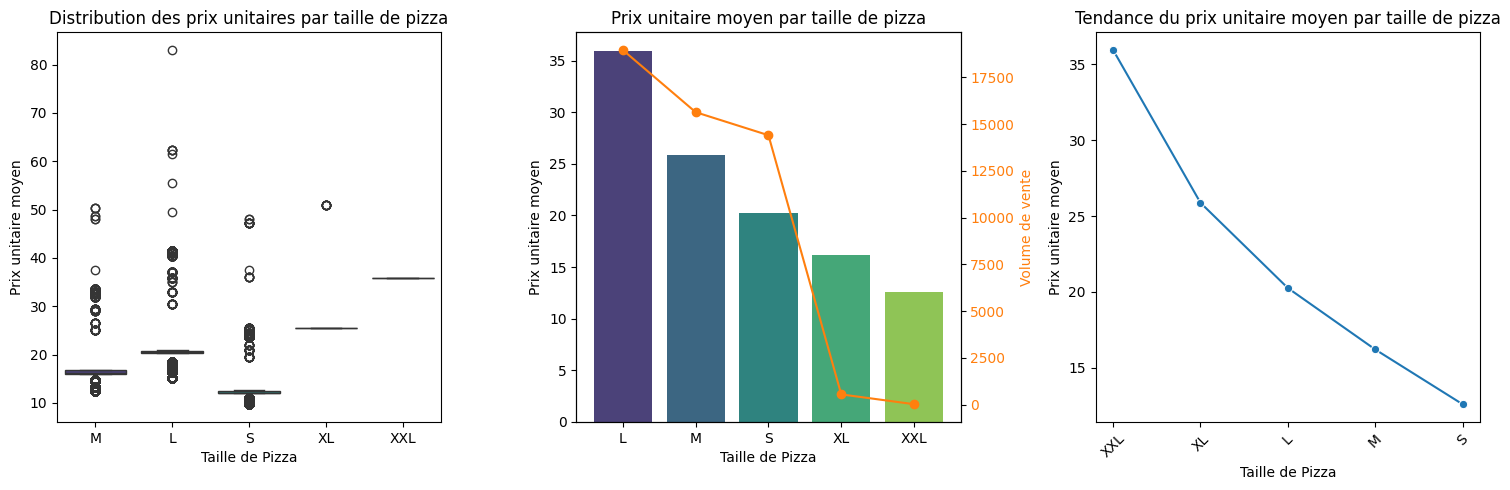

Prix moyen par taille de pizza :
 pizza_size
XXL    35.95
XL     25.88
L      20.26
M      16.21
S      12.60
Name: total_price, dtype: float64

Volume de vente par taille de pizza :
 pizza_size
L      18956
M      15635
S      14403
XL       552
XXL       28
Name: quantity, dtype: int64


In [107]:
price_unit_mean = df.groupby('pizza_size')['total_price'].mean().round(2).sort_values(ascending=False)
volume_of_sales = df.groupby('pizza_size')['quantity'].sum().sort_values(ascending=False)

#sous-plots sur une seule ligne
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Graph1
sns.boxplot(x='pizza_size', y='total_price', data=df, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Taille de Pizza')
axes[0].set_ylabel('Prix unitaire moyen')
axes[0].set_title('Distribution des prix unitaires par taille de pizza')

# Graph2
sns.barplot(x=price_unit_mean.index, y=price_unit_mean.values, palette='viridis', ax=axes[1])
axes[1].set_xlabel('Taille de Pizza')
axes[1].set_ylabel('Prix unitaire moyen')
axes[1].set_title('Prix unitaire moyen par taille de pizza')

# Graph3
sns.lineplot(x=price_unit_mean.index, y=price_unit_mean.values, marker='o', ax=axes[2])
axes[2].set_xlabel('Taille de Pizza')
axes[2].set_ylabel('Prix unitaire moyen')
axes[2].set_title('Tendance du prix unitaire moyen par taille de pizza')
axes[2].tick_params(axis='x', rotation=45)

# Deuxième axe y volume de vente (Graph 2)
ax2 = axes[1].twinx()
color = 'tab:orange'
ax2.set_ylabel('Volume de vente', color=color)
ax2.plot(volume_of_sales.index, volume_of_sales.values, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout()
plt.show()

print("Prix moyen par taille de pizza :\n", price_unit_mean)
print("\nVolume de vente par taille de pizza :\n", volume_of_sales)

### **13.Tendances saisonnières :**

a. Y a-t-il des tendances saisonnières dans les commandes de pizza ?

J'ai proposé diférents grphiques permettants de visualiser des tendances subjectives.

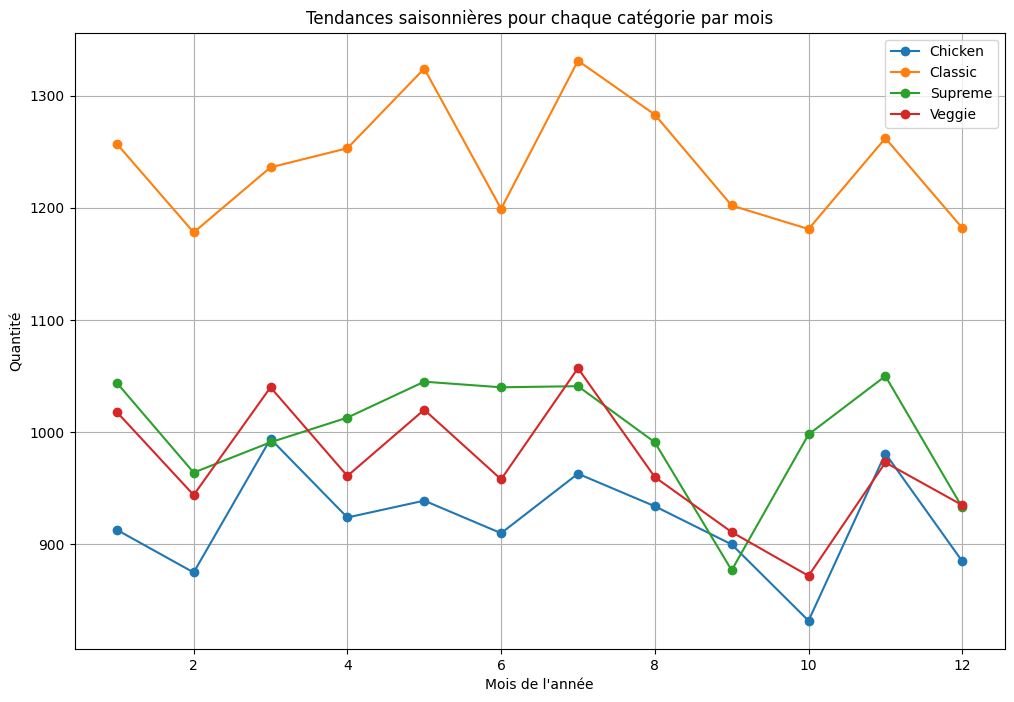

In [108]:
df['order_date'] = pd.to_datetime(df['order_date'])

df['order_month'] = df['order_date'].dt.month

monthly_trends = df.groupby(['order_month', 'pizza_category']).agg({'quantity': 'sum'}).reset_index()

pivot_table = monthly_trends.pivot(index='order_month', columns='pizza_category', values='quantity')

plt.figure(figsize=(12, 8))

for category in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[category], label=category, marker='o')

plt.title('Tendances saisonnières pour chaque catégorie par mois')
plt.xlabel('Mois de l\'année')
plt.ylabel('Quantité')
plt.legend()
plt.grid(True)
plt.show()

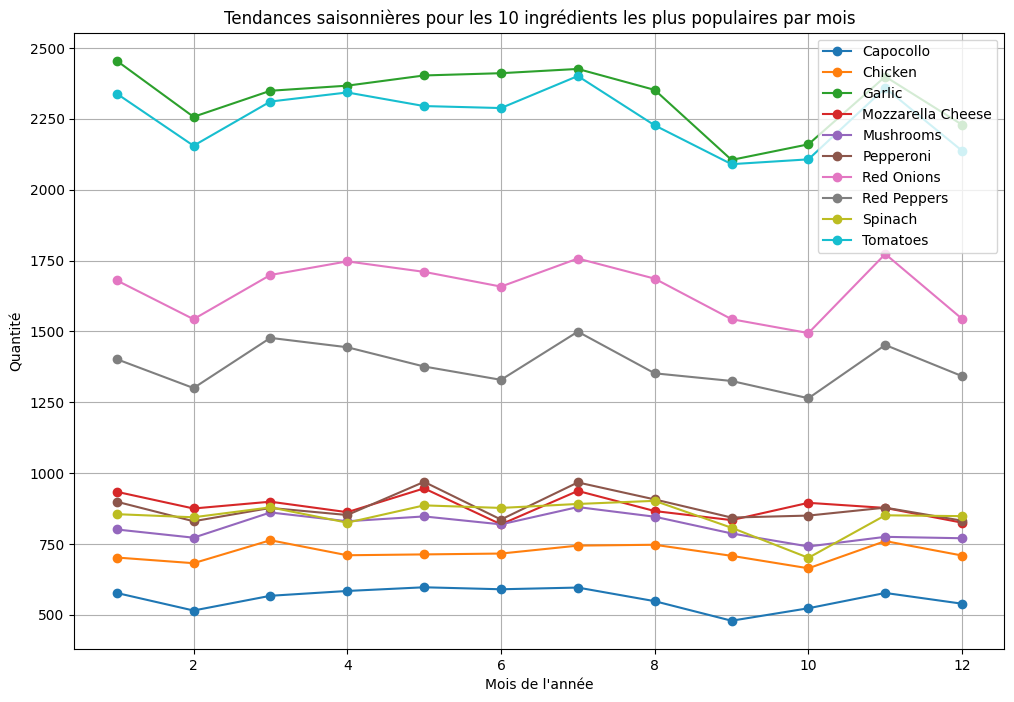

In [109]:
df['order_date'] = pd.to_datetime(df['order_date'])

df['order_month'] = df['order_date'].dt.month

ingredients_lists = df['pizza_ingredients'].str.split(', ')

df_exploded = df.assign(pizza_ingredients=ingredients_lists).explode('pizza_ingredients')

top_5_ingredients = df_exploded['pizza_ingredients'].value_counts().nlargest(10).index

df_top_5_ingredients = df_exploded[df_exploded['pizza_ingredients'].isin(top_5_ingredients)]

monthly_trends = df_top_5_ingredients.groupby(['order_month', 'pizza_ingredients']).agg({'quantity': 'sum'}).reset_index()
pivot_table = monthly_trends.pivot(index='order_month', columns='pizza_ingredients', values='quantity')

plt.figure(figsize=(12, 8))

for ingredient in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[ingredient], label=ingredient, marker='o')

plt.title('Tendances saisonnières pour les 10 ingrédients les plus populaires par mois')
plt.xlabel('Mois de l\'année')
plt.ylabel('Quantité')
plt.legend()
plt.grid(True)
plt.show()

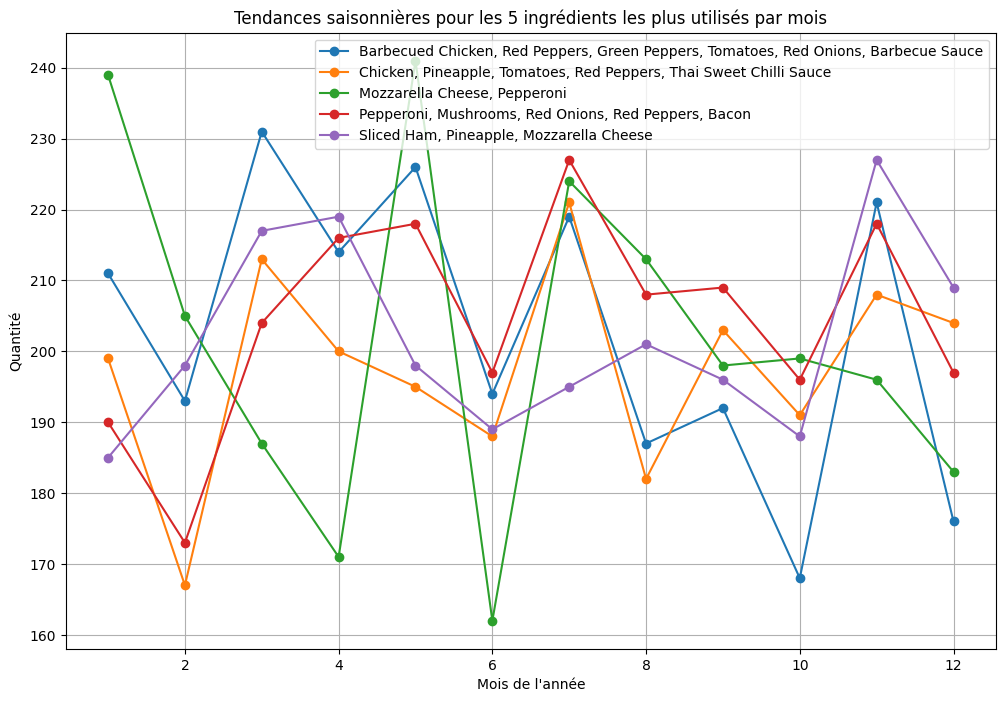

In [110]:
df['order_date'] = pd.to_datetime(df['order_date'])

df['order_month'] = df['order_date'].dt.month

monthly_trends = df.groupby(['order_month', 'pizza_ingredients']).agg({'quantity': 'sum'}).reset_index()

# Sélectionner les 5 ingrédients les plus utilisés
top_5_ingredients = df.groupby('pizza_ingredients')['quantity'].sum().nlargest(5).index
filtered_data = monthly_trends[monthly_trends['pizza_ingredients'].isin(top_5_ingredients)]

pivot_table = filtered_data.pivot(index='order_month', columns='pizza_ingredients', values='quantity')

plt.figure(figsize=(12, 8))

for ingredient in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[ingredient], label=ingredient, marker='o')

plt.title('Tendances saisonnières pour les 5 ingrédients les plus utilisés par mois')
plt.xlabel('Mois de l\'année')
plt.ylabel('Quantité')
plt.legend()
plt.grid(True)
plt.show()

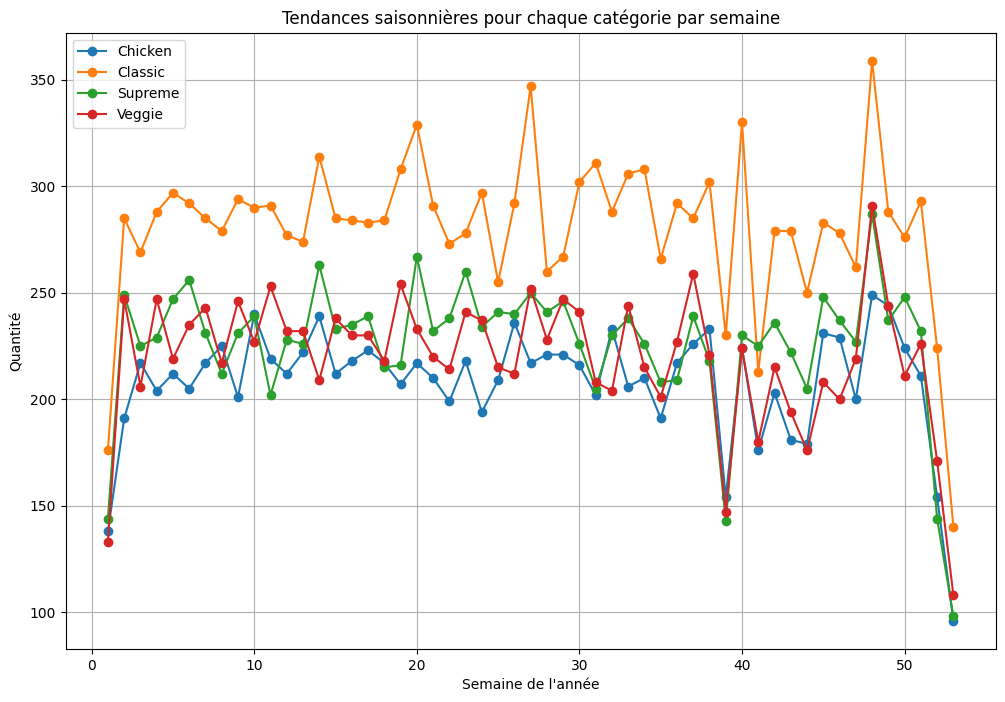

In [111]:
df['order_date'] = pd.to_datetime(df['order_date'])

df['order_week'] = df['order_date'].dt.isocalendar().week

weekly_trends = df.groupby(['order_week', 'pizza_category']).agg({'quantity': 'sum'}).reset_index()

pivot_table = weekly_trends.pivot(index='order_week', columns='pizza_category', values='quantity')

plt.figure(figsize=(12, 8))

for category in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[category], label=category, marker='o')

plt.title('Tendances saisonnières pour chaque catégorie par semaine')
plt.xlabel('Semaine de l\'année')
plt.ylabel('Quantité')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-112-d0813c0b5036>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['order_month'] = filtered_data['order_month'].astype(str)


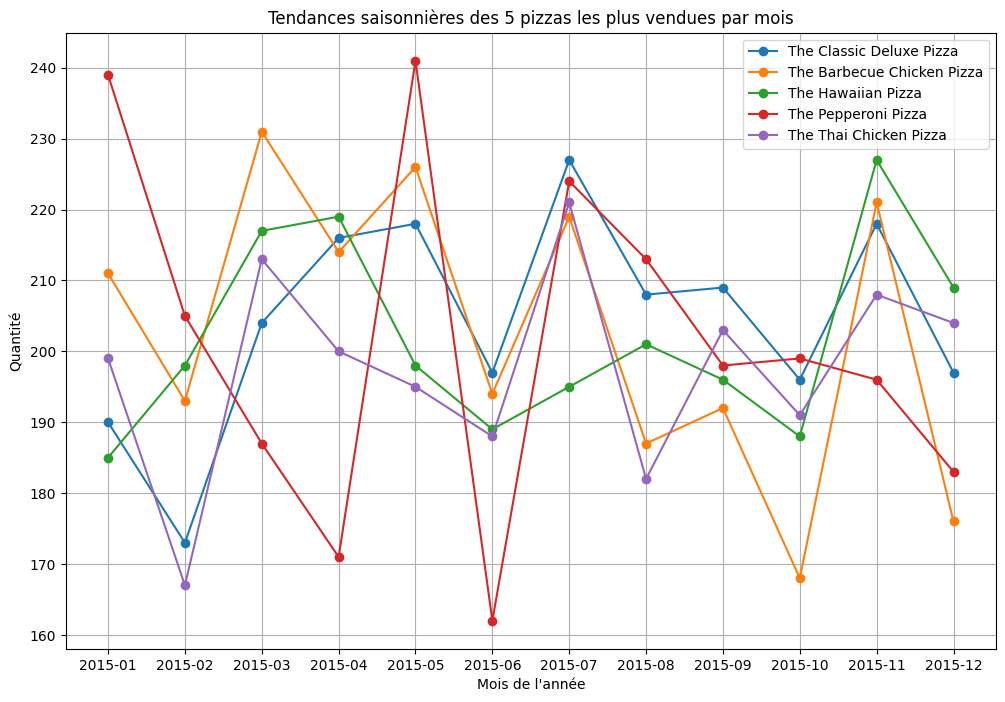

In [112]:
df['order_date'] = pd.to_datetime(df['order_date'])

df['order_month'] = df['order_date'].dt.to_period('M')

monthly_trends = df.groupby(['order_month', 'pizza_name']).agg({'quantity': 'sum'}).reset_index()

top_5_pizzas = df.groupby('pizza_name')['quantity'].sum().nlargest(5).index
filtered_data = monthly_trends[monthly_trends['pizza_name'].isin(top_5_pizzas)]

filtered_data['order_month'] = filtered_data['order_month'].astype(str)

plt.figure(figsize=(12, 8))

for pizza_name in top_5_pizzas:
    pizza_data = filtered_data[filtered_data['pizza_name'] == pizza_name]
    plt.plot(pizza_data['order_month'], pizza_data['quantity'], label=pizza_name, marker='o')

plt.title('Tendances saisonnières des 5 pizzas les plus vendues par mois')
plt.xlabel('Mois de l\'année')
plt.ylabel('Quantité')
plt.legend()
plt.grid(True)
plt.show()

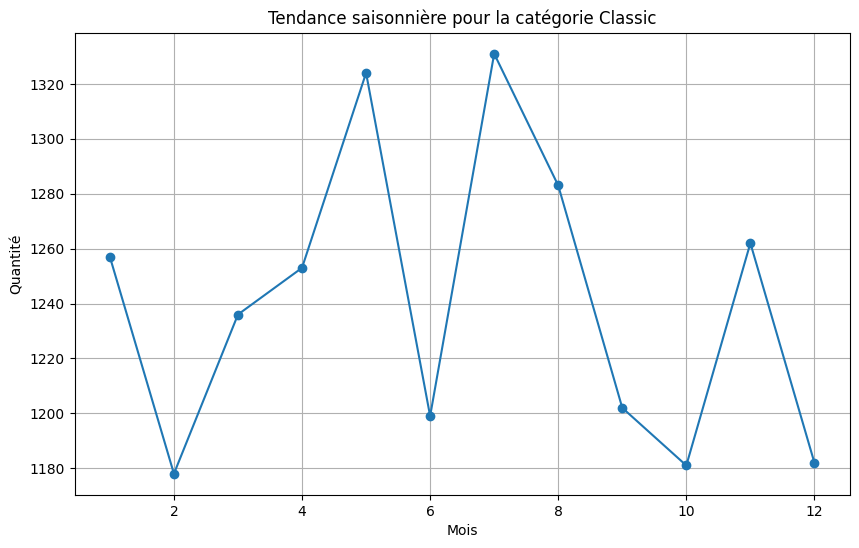

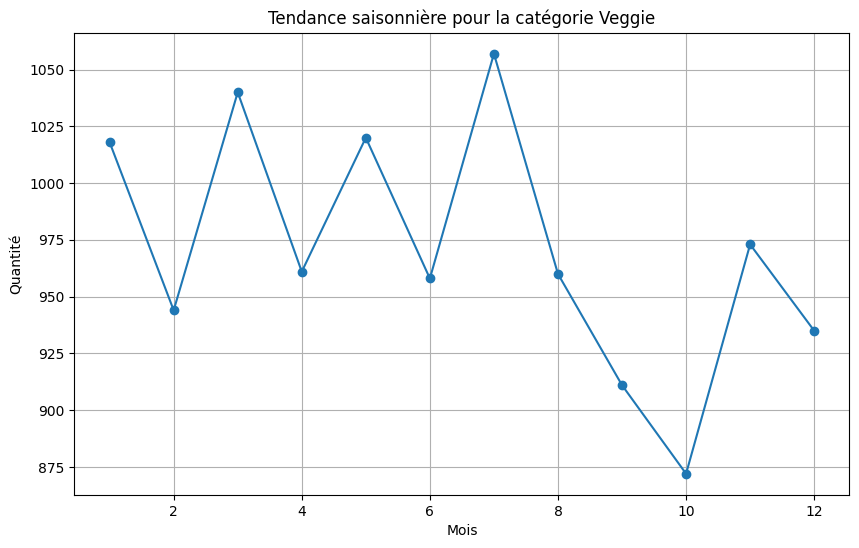

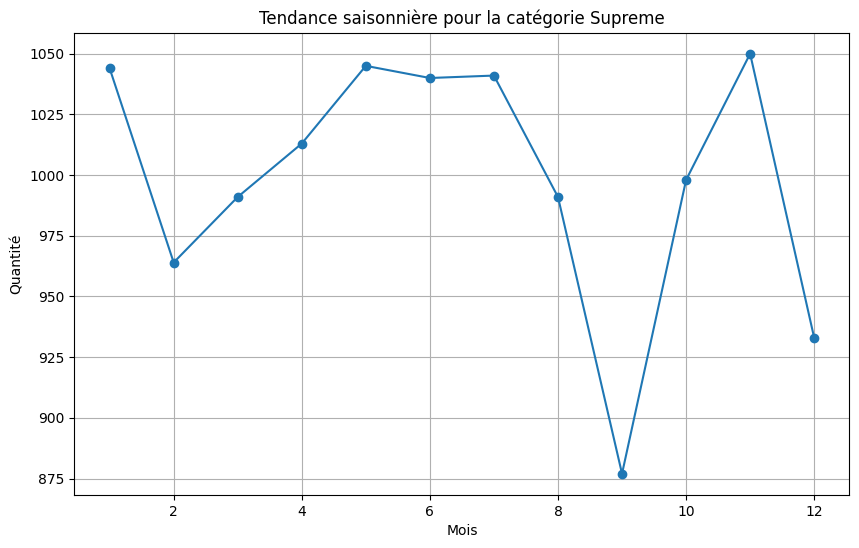

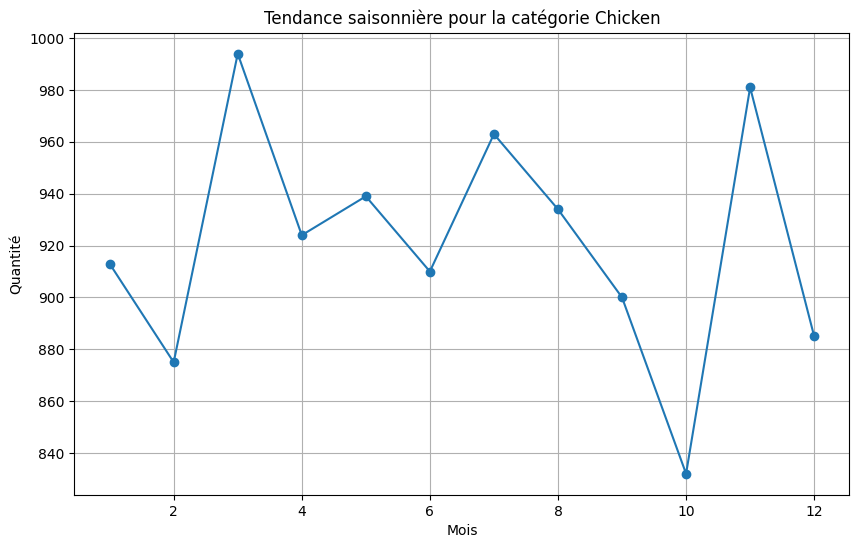

In [113]:
df['order_date'] = pd.to_datetime(df['order_date'])

df['order_month'] = df['order_date'].dt.month

monthly_trends = df.groupby(['order_month', 'pizza_category']).agg({'quantity': 'sum'}).reset_index()

categories = df['pizza_category'].unique()

for category in categories:
    category_data = monthly_trends[monthly_trends['pizza_category'] == category]

    plt.figure(figsize=(10, 6))
    plt.plot(category_data['order_month'], category_data['quantity'], marker='o')
    plt.title(f'Tendance saisonnière pour la catégorie {category}')
    plt.xlabel('Mois')
    plt.ylabel('Quantité')
    plt.grid(True)
    plt.show()

**b. Y a-t-il une corrélation entre le jour de la semaine et la quantité de commandes ?**

Les matrices ne confirment pas la corrélation mais nous pouvons observer grace au volume de CA, une poussée signifiante sur les lignes, du **VENDRDI** sur le diagramme en secteur, diagramme en barres. L'effet loupe du diagramme en barre permet de noter ce fort volume de CA, conséquent.

 Matrice de Cramer :

Chaque ligne et colonne de la matrice correspond à un jour de la semaine.
Les valeurs dans la matrice représentent la corrélation de Cramer entre les jours de la semaine associés à ces lignes et colonnes et la quantité de commandes.
Les valeurs de la matrice sont interprétées comme suit :

Plus la valeur est proche de 1, plus il y a une forte association entre le jour de la semaine et la quantité de commandes.
Une valeur proche de 0 indique une faible association.

**Nous nottons les valeurs des différentes tentatives de corrélation proche de zero, donc aucune corrélation observée.**

In [124]:
from scipy.stats import chi2_contingency

df['order_date'] = pd.to_datetime(df['order_date'])
df['day_of_week'] = df['order_date'].dt.day_name()
ca_par_jour_de_semaine = df.groupby('day_of_week')['total_price'].sum()
print(ca_par_jour_de_semaine)

print()

confusion_matrix = pd.crosstab(df['day_of_week'], df['quantity'])
_, _, _, correlation_cramer = chi2_contingency(confusion_matrix)
print(f"Corrélation de Cramer : {correlation_cramer}")

day_of_week
Friday       136073.90
Monday       107329.55
Saturday     123182.40
Sunday        99203.50
Thursday     123528.50
Tuesday      114133.80
Wednesday    114408.40
Name: total_price, dtype: float64

Corrélation de Cramer : [[7.95144916e+03 1.50549527e+02 3.50115179e+00 5.00164541e-01]
 [6.24756719e+03 1.18288914e+02 2.75090498e+00 3.92986425e-01]
 [7.21476789e+03 1.36601501e+02 3.17677910e+00 4.53825586e-01]
 [5.80418513e+03 1.09894097e+02 2.55567668e+00 3.65096668e-01]
 [7.18337801e+03 1.36007178e+02 3.16295763e+00 4.51851090e-01]
 [6.62424576e+03 1.25420794e+02 2.91676265e+00 4.16680378e-01]
 [6.66740685e+03 1.26237988e+02 2.93576717e+00 4.19395311e-01]]


La valeur de corrélation de point bisérial que vous avez obtenue est proche de zéro (0.012). Cela indique une faible corrélation entre le jour de la semaine et la quantité de commandes. **Il n'y a pas de corrélation significative entre le jour de la semaine et la quantité de commandes.**

In [115]:
from scipy.stats import pointbiserialr
correlation_point_biserial, _ = pointbiserialr(df['day_of_week'].astype('category').cat.codes, df['quantity'])
print(f"Corrélation de Point bisérial : {correlation_point_biserial}")

Corrélation de Point bisérial : 0.01206005774885429


**La valeur de corrélation de Kendall que vous avez obtenue est également proche de zéro (0.0115), ce qui indique une faible corrélation entre le jour de la semaine et la quantité de commandes.** Comme pour la corrélation de point bisérial, une valeur proche de zéro suggère qu'il n'y a pas de corrélation significative entre ces deux variables.

Le jour de la semaine ne semble pas avoir une influence majeure sur la quantité de commandes.

In [116]:
correlation_kendall = df['day_of_week'].corr(df['quantity'], method='kendall')
print(f"Corrélation de Kendall : {correlation_kendall}")

Corrélation de Kendall : 0.011464808391356458


**La valeur de corrélation de Spearman est également proche de zéro (0.0131), indiquant une faible corrélation monotone entre le jour de la semaine et la quantité de commandes.**

In [121]:
correlation_spearman = df['day_of_week'].corr(df['quantity'], method='spearman')
print(f"Corrélation de Spearman : {correlation_spearman}")

Corrélation de Spearman : 0.013131477726572725


month  day_of_week
1      Monday          8256.55
       Tuesday         9404.50
       Wednesday       8786.15
       Thursday       12079.00
       Friday         12147.40
                        ...   
12     Wednesday      10602.55
       Thursday       11163.40
       Friday          8398.65
       Saturday        8535.35
       Sunday          8119.30
Name: total_price, Length: 84, dtype: float64


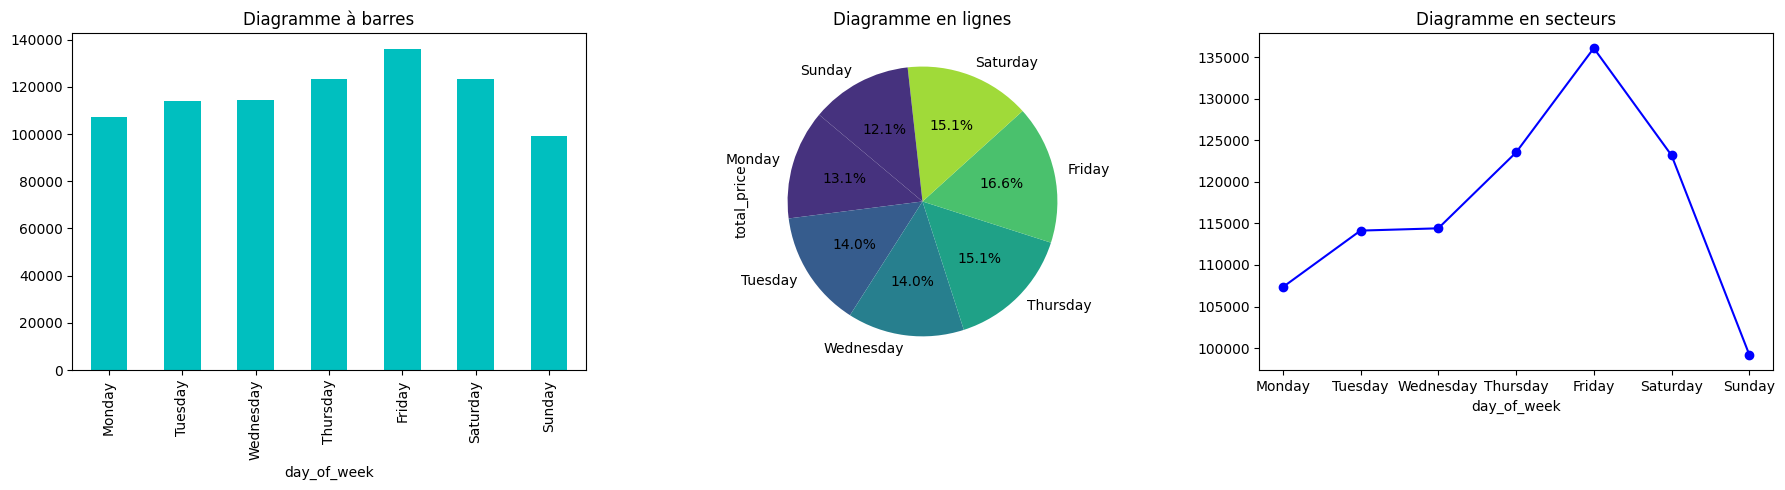

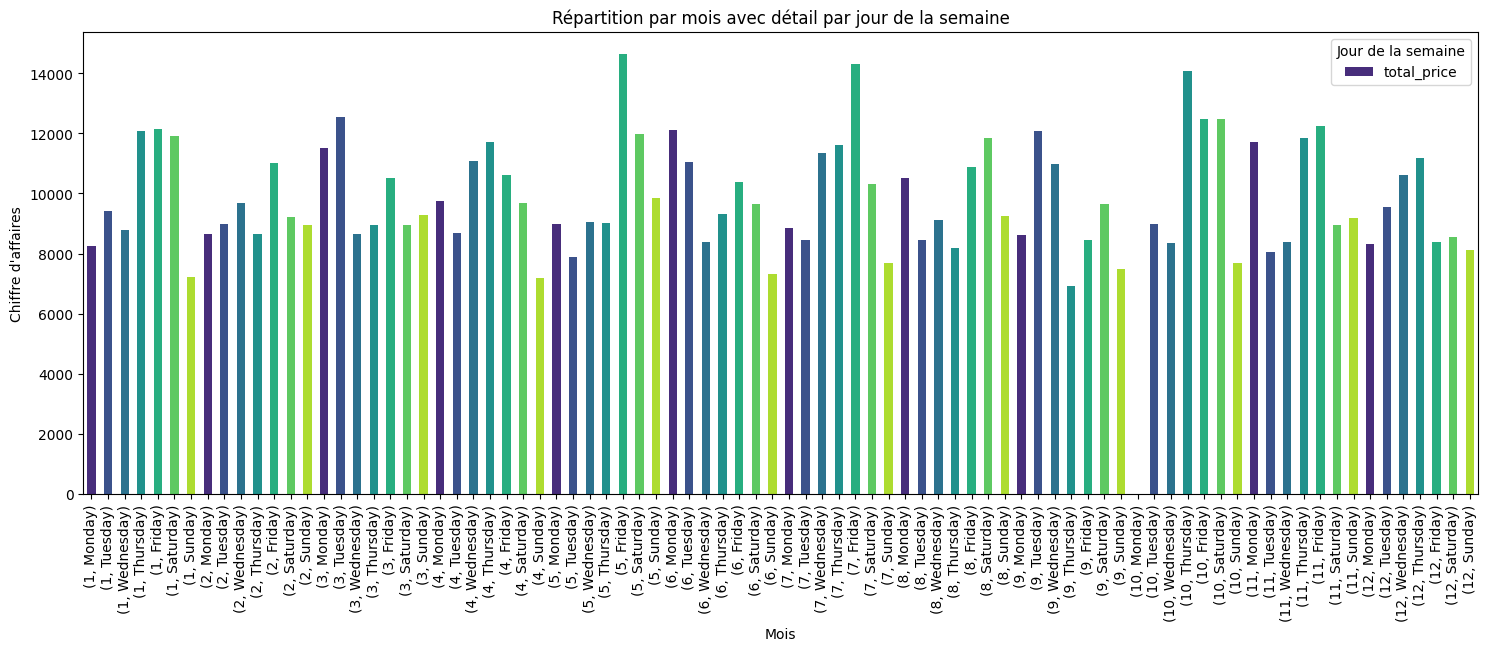

In [123]:
df['order_date'] = pd.to_datetime(df['order_date'])

df['day_of_week'] = df['order_date'].dt.day_name()
ca_par_jour_de_semaine = df.groupby('day_of_week')['total_price'].sum()

jours_de_semaine_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ca_par_jour_de_semaine = ca_par_jour_de_semaine.reindex(jours_de_semaine_ordre)

#--------------------
df['month'] = df['order_date'].dt.month
# Calculer les sommes par mois et par jour de la semaine
ca_par_mois_jour_max = df.groupby(['month', 'day_of_week'])['total_price'].sum()

jours_de_semaine_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ca_par_mois_jour_max = ca_par_mois_jour_max.reindex(pd.MultiIndex.from_product([range(1, 13), jours_de_semaine_ordre], names=['month', 'day_of_week']))
print(ca_par_mois_jour_max)

#---------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ca_par_jour_de_semaine.plot(kind='bar', ax=axes[0], color='c')
axes[0].set_title('Diagramme à barres')

ca_par_jour_de_semaine.plot(kind='line', marker='o', ax=axes[2], color='b')
axes[1].set_title('Diagramme en lignes')

ca_par_jour_de_semaine.plot(kind='pie', autopct='%1.1f%%', startangle=140, ax=axes[1], colors=sns.color_palette('viridis'))
axes[2].set_title('Diagramme en secteurs')

plt.tight_layout()
plt.show()

# ----------------------
viridis_palette = sns.color_palette("viridis", n_colors=7)

fig, ax = plt.subplots(figsize=(18, 6))

# Utilisez ca_par_mois_jour_max au lieu de ca_par_mois_jour
ca_par_mois_jour_max.plot(kind='bar', stacked=True, ax=ax, color=viridis_palette)

ax.set_title('Répartition par mois avec détail par jour de la semaine')
ax.set_xlabel('Mois')
ax.set_ylabel("Chiffre d'affaires")
ax.legend(title='Jour de la semaine')

plt.show()

In [129]:
df.columns
df

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,rounded_order_time,year_month,order_month,order_week,day_of_week,month
0,1,1,hawaiian_m,1,2015-01-01,1900-01-01 12:00:00,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,1900-01-01 11:30:00,2015-01,1,1,Thursday,1
1,2,2,classic_dlx_m,1,2015-01-01,1900-01-01 12:00:00,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,1900-01-01 11:30:00,2015-01,1,1,Thursday,1
2,3,2,five_cheese_l,1,2015-01-01,1900-01-01 12:00:00,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,1900-01-01 11:30:00,2015-01,1,1,Thursday,1
3,4,2,ital_supr_l,1,2015-01-01,1900-01-01 12:00:00,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,1900-01-01 11:30:00,2015-01,1,1,Thursday,1
4,5,2,mexicana_m,1,2015-01-01,1900-01-01 12:00:00,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,1900-01-01 11:30:00,2015-01,1,1,Thursday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,2015-12-31,1900-01-01 21:00:00,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza,1900-01-01 21:00:00,2015-12,12,53,Thursday,12
48616,48617,21348,four_cheese_l,1,2015-12-31,1900-01-01 21:00:00,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza,1900-01-01 21:00:00,2015-12,12,53,Thursday,12
48617,48618,21348,napolitana_s,1,2015-12-31,1900-01-01 21:00:00,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,1900-01-01 21:00:00,2015-12,12,53,Thursday,12
48618,48619,21349,mexicana_l,1,2015-12-31,1900-01-01 22:00:00,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,1900-01-01 22:00:00,2015-12,12,53,Thursday,12


<ipython-input-131-93671a2d8e59>:27: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


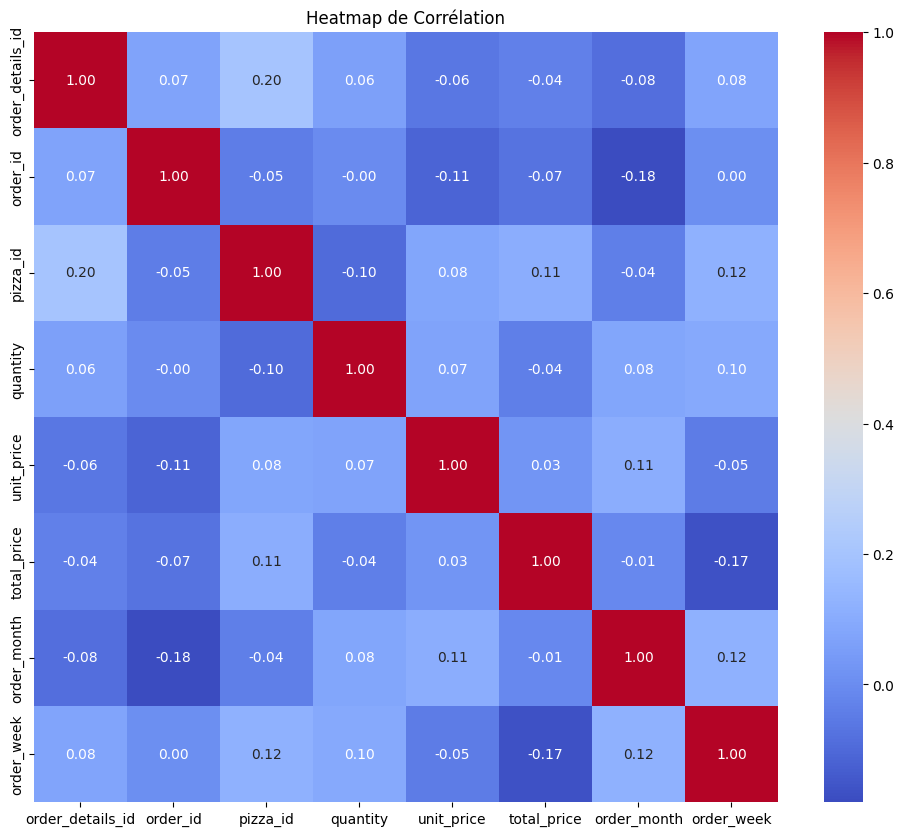

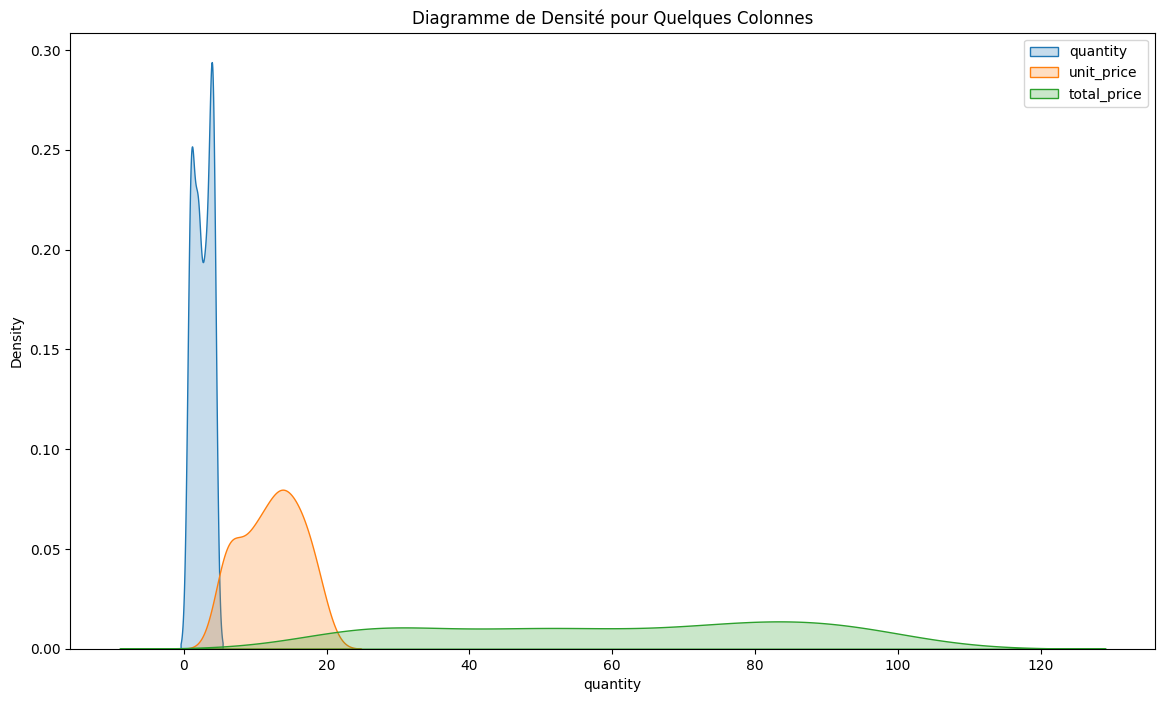

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Création d'un dataframe avec des données fictives
np.random.seed(42)
data = pd.DataFrame({
    'order_details_id': np.random.randint(1, 100, 100),
    'order_id': np.random.randint(1000, 1100, 100),
    'pizza_id': np.random.randint(1, 50, 100),
    'quantity': np.random.randint(1, 5, 100),
    'unit_price': np.random.uniform(5, 20, 100),
    'total_price': np.random.uniform(20, 100, 100),
    'pizza_size': np.random.choice(['Small', 'Medium', 'Large'], 100),
    'pizza_category': np.random.choice(['Vegetarian', 'Meat Lovers', 'Supreme'], 100),
    'pizza_ingredients': np.random.choice(['Mushrooms', 'Pepperoni', 'Onions'], 100),
    'pizza_name': np.random.choice(['Margherita', 'Pepperoni Feast', 'Vegetarian Deluxe'], 100),
    'rounded_order_time': np.random.choice(['12:00 PM', '6:00 PM', '9:00 PM'], 100),
    'order_month': np.random.randint(1, 13, 100),
    'order_week': np.random.randint(1, 5, 100),
    'day_of_week': np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 100),
    'month': np.random.choice(['January', 'February', 'March', 'April', 'May'], 100)
})

# Heatmap de corrélation
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Corrélation')
plt.show()

# Diagramme de densité pour quelques colonnes
plt.figure(figsize=(14, 8))
columns_for_density = ['quantity', 'unit_price', 'total_price']
for column in columns_for_density:
    sns.kdeplot(data[column], label=column, fill=True)
plt.title('Diagramme de Densité pour Quelques Colonnes')
plt.legend()
plt.show()



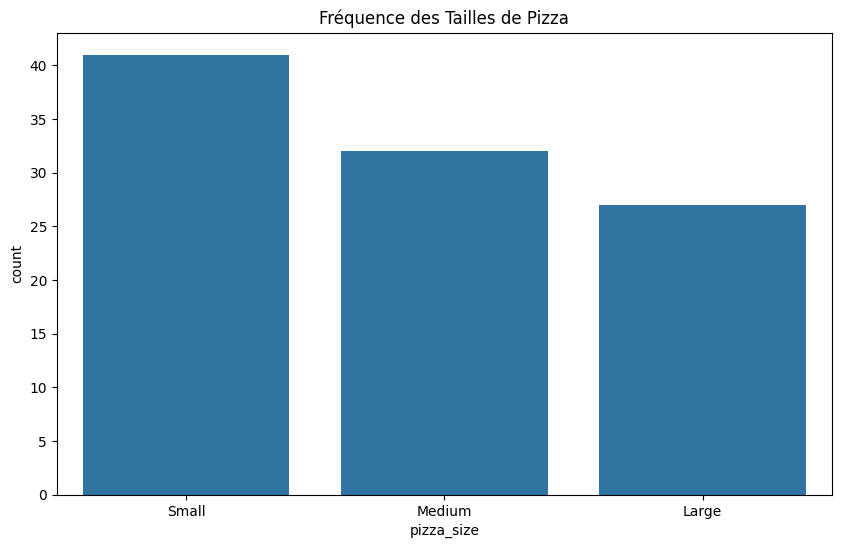

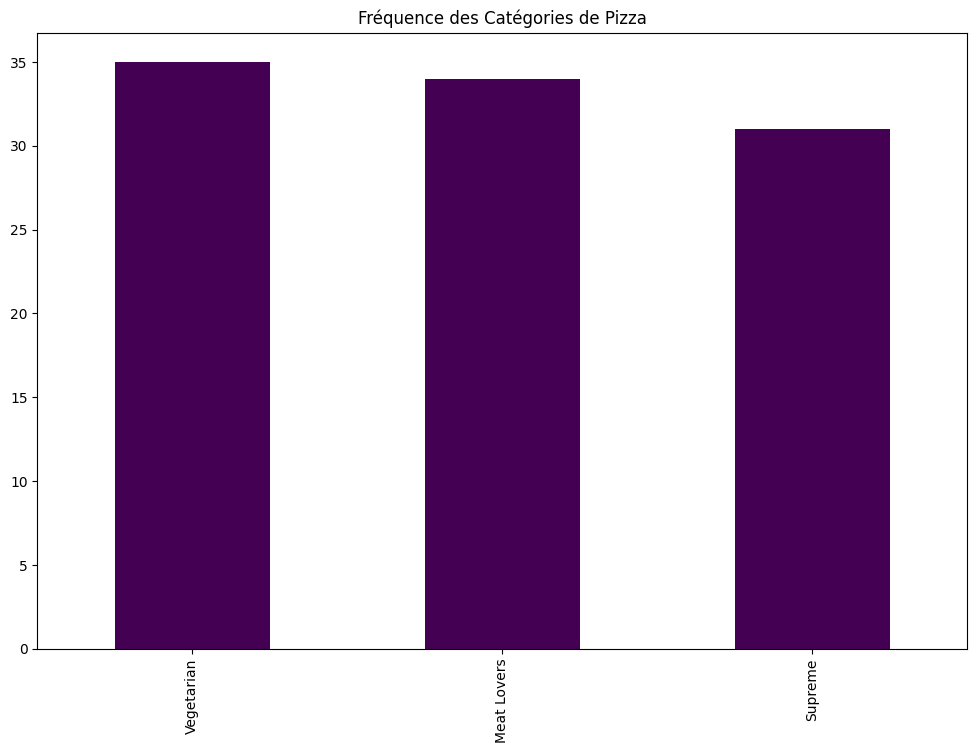

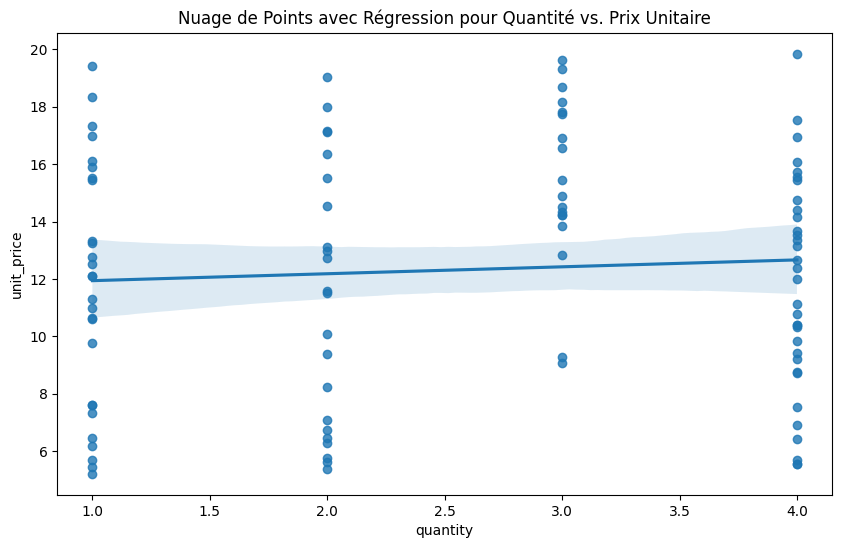

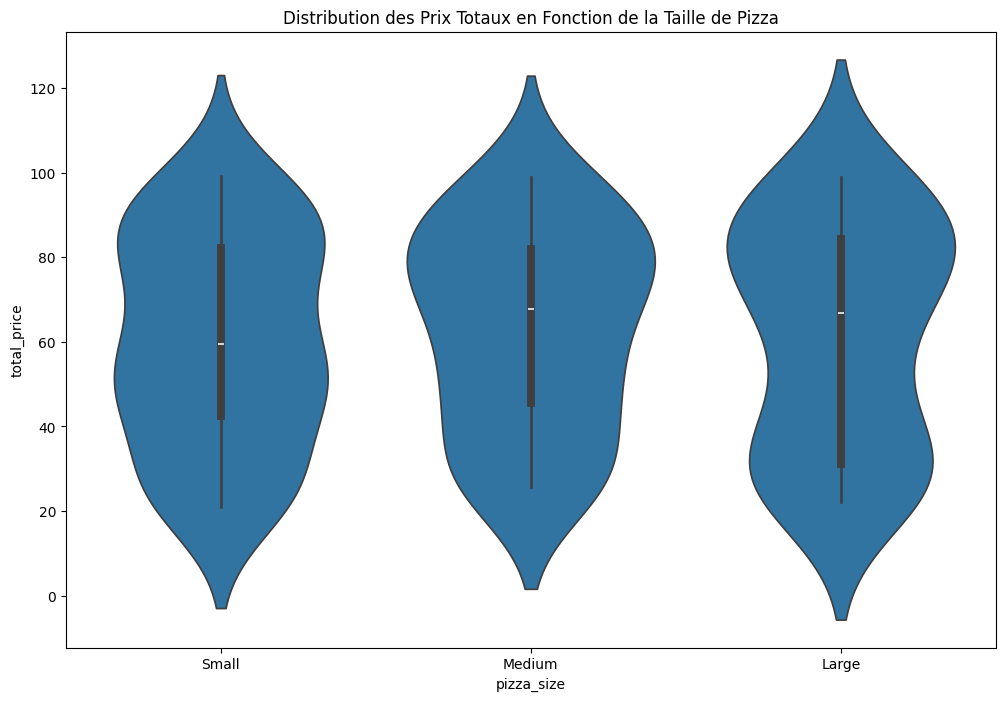

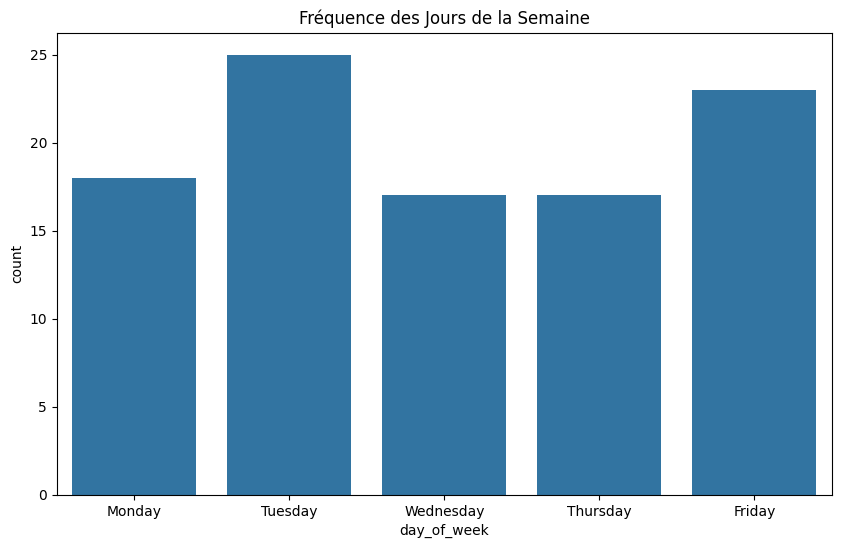

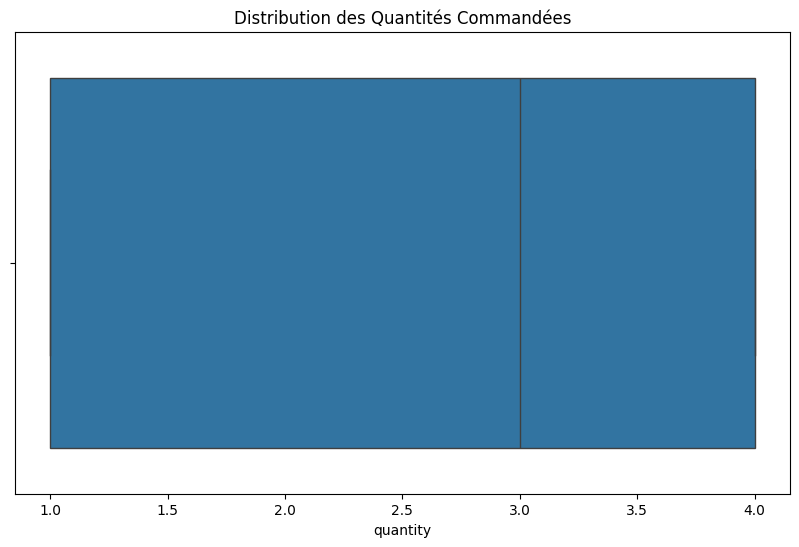

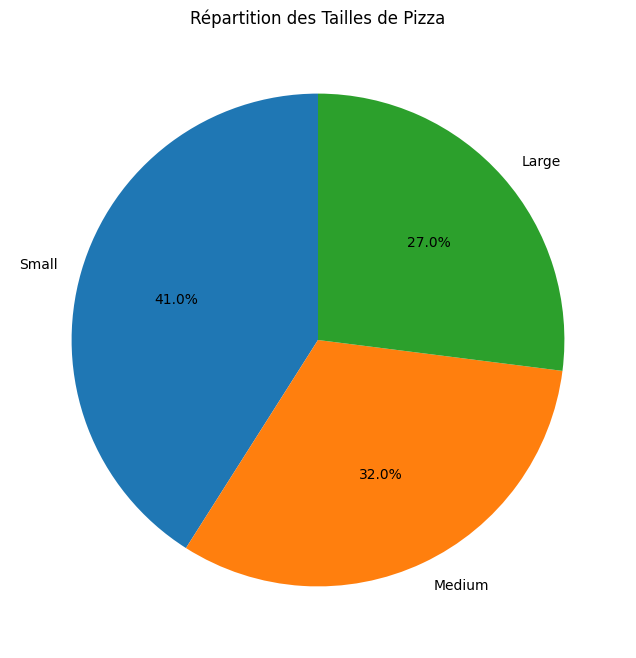

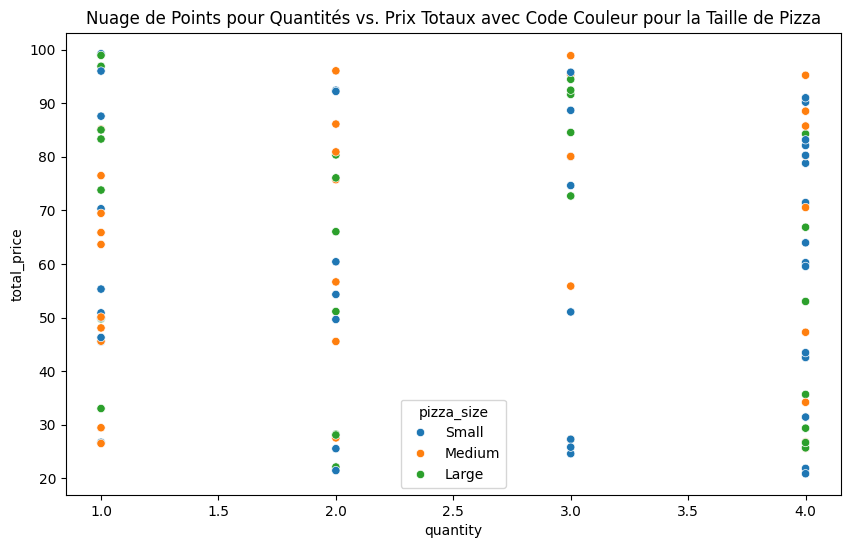

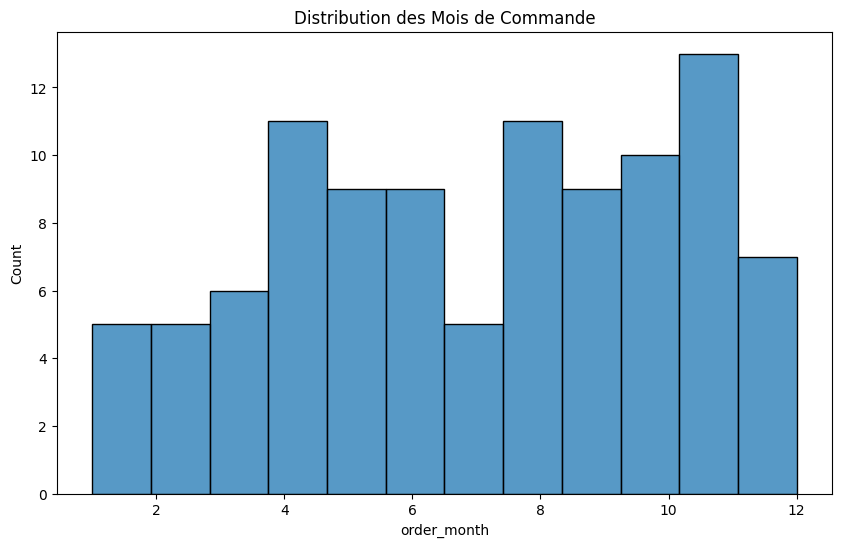

KeyError: 'year'

In [137]:
plt.figure(figsize=(10, 6))
sns.countplot(x='pizza_size', data=data)
plt.title('Fréquence des Tailles de Pizza')
plt.show()

plt.figure(figsize=(12, 8))
category_count = data['pizza_category'].value_counts()
category_count.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Fréquence des Catégories de Pizza')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x='quantity', y='unit_price', data=data)
plt.title('Nuage de Points avec Régression pour Quantité vs. Prix Unitaire')
plt.show()

plt.figure(figsize=(12, 8))
sns.violinplot(x='pizza_size', y='total_price', data=data)
plt.title('Distribution des Prix Totaux en Fonction de la Taille de Pizza')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=data, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.title('Fréquence des Jours de la Semaine')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='quantity', data=data)
plt.title('Distribution des Quantités Commandées')
plt.show()

plt.figure(figsize=(8, 8))
size_counts = data['pizza_size'].value_counts()
plt.pie(size_counts, labels=size_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Répartition des Tailles de Pizza')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='quantity', y='total_price', hue='pizza_size', data=data)
plt.title('Nuage de Points pour Quantités vs. Prix Totaux avec Code Couleur pour la Taille de Pizza')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(x='order_month', data=data, bins=12, multiple='stack')
plt.title('Distribution des Mois de Commande')
plt.show()

# Création d'une colonne 'year_month' en combinant 'year' et 'order_month'
data['year_month'] = data['year'].astype(str) + '-' + data['order_month'].astype(str)

# Diagramme en barres pour la fréquence des années-mois
plt.figure(figsize=(12, 6))
sns.countplot(x='year_month', data=data.sort_values('year_month'))
plt.title('Fréquence des Années-Mois de Commande')
plt.xticks(rotation=45)
plt.show()



KeyError: 'ca_heure'

In [142]:
df.columns


Index(['order_details_id', 'order_id', 'pizza_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'rounded_order_time', 'year_month', 'order_month', 'order_week',
       'day_of_week', 'month'],
      dtype='object')


Statistiques descriptives pour la colonne 'order_details_id':

Moyenne et Médiane :
Moyenne : 3.0
Médiane : 3.0

Écart-type et Somme :
Écart-type : 1.5811388300841898
Somme : 15

Min, Max et Valeurs uniques :
Valeur minimale : 1
Valeur maximale : 5
Valeurs uniques : [1 2 3 4 5]

Histogramme et Diagramme de Densité :


<ipython-input-146-64e291e1d23a>:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[column], kde=True, palette='viridis')


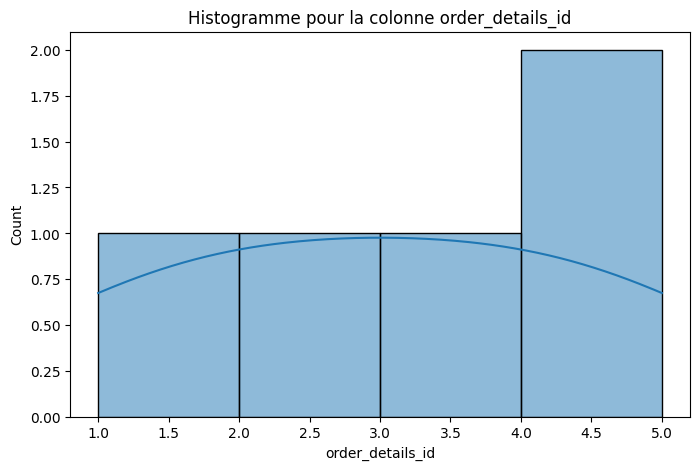

<ipython-input-146-64e291e1d23a>:51: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df[column], fill=True, palette='viridis')


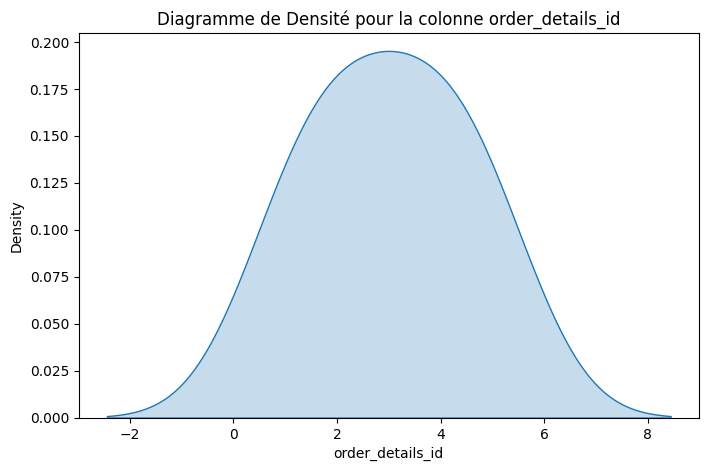


Résumé statistique complet :
count    5.000000
mean     3.000000
std      1.581139
min      1.000000
25%      2.000000
50%      3.000000
75%      4.000000
max      5.000000
Name: order_details_id, dtype: float64

Corrélation avec 'order_week' :
Corrélation : nan

Covariance avec 'order_week' :
Covariance : 0.0

Taille de l'échantillon :
Taille de l'échantillon : 5

Corrélation entre les colonnes :
                  order_details_id  order_id  pizza_id  quantity  unit_price  \
order_details_id          1.000000  1.000000  1.000000  0.693375    0.359717   
order_id                  1.000000  1.000000  1.000000  0.693375    0.359717   
pizza_id                  1.000000  1.000000  1.000000  0.693375    0.359717   
quantity                  0.693375  0.693375  0.693375  1.000000   -0.341087   
unit_price                0.359717  0.359717  0.359717 -0.341087    1.000000   
total_price               0.846412  0.846412  0.846412  0.949440   -0.031158   
order_month                    NaN    

<ipython-input-146-64e291e1d23a>:68: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())
<ipython-input-146-64e291e1d23a>:71: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.cov())
<ipython-input-146-64e291e1d23a>:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[column], kde=True, palette='viridis')


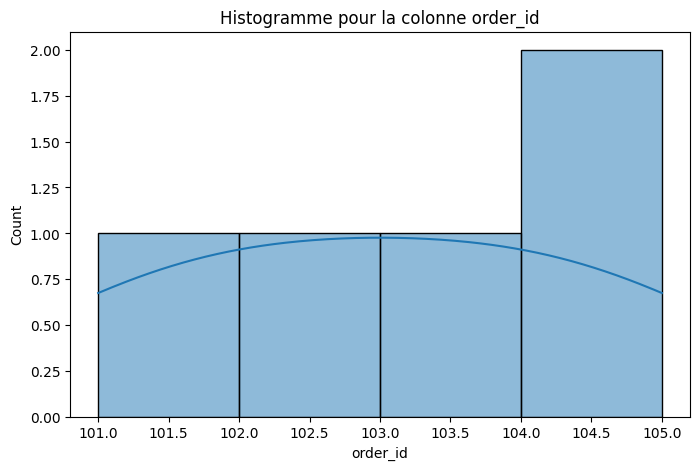

<ipython-input-146-64e291e1d23a>:51: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df[column], fill=True, palette='viridis')


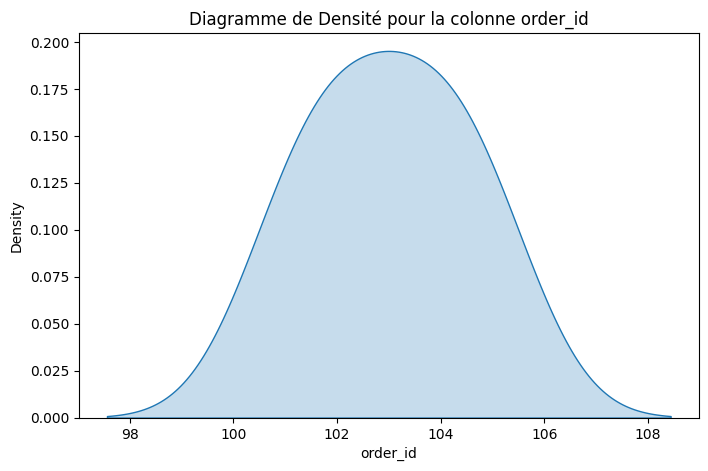


Résumé statistique complet :
count      5.000000
mean     103.000000
std        1.581139
min      101.000000
25%      102.000000
50%      103.000000
75%      104.000000
max      105.000000
Name: order_id, dtype: float64

Corrélation avec 'order_week' :
Corrélation : nan

Covariance avec 'order_week' :
Covariance : 0.0

Taille de l'échantillon :
Taille de l'échantillon : 5

Corrélation entre les colonnes :
                  order_details_id  order_id  pizza_id  quantity  unit_price  \
order_details_id          1.000000  1.000000  1.000000  0.693375    0.359717   
order_id                  1.000000  1.000000  1.000000  0.693375    0.359717   
pizza_id                  1.000000  1.000000  1.000000  0.693375    0.359717   
quantity                  0.693375  0.693375  0.693375  1.000000   -0.341087   
unit_price                0.359717  0.359717  0.359717 -0.341087    1.000000   
total_price               0.846412  0.846412  0.846412  0.949440   -0.031158   
order_month                   

<ipython-input-146-64e291e1d23a>:68: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())
<ipython-input-146-64e291e1d23a>:71: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.cov())
<ipython-input-146-64e291e1d23a>:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[column], kde=True, palette='viridis')


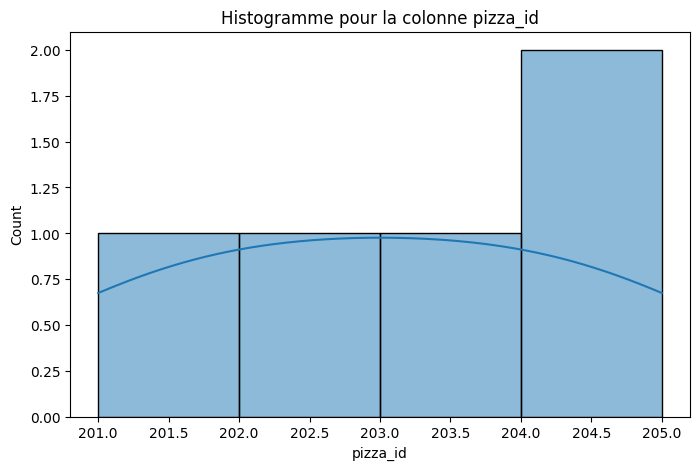

<ipython-input-146-64e291e1d23a>:51: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df[column], fill=True, palette='viridis')


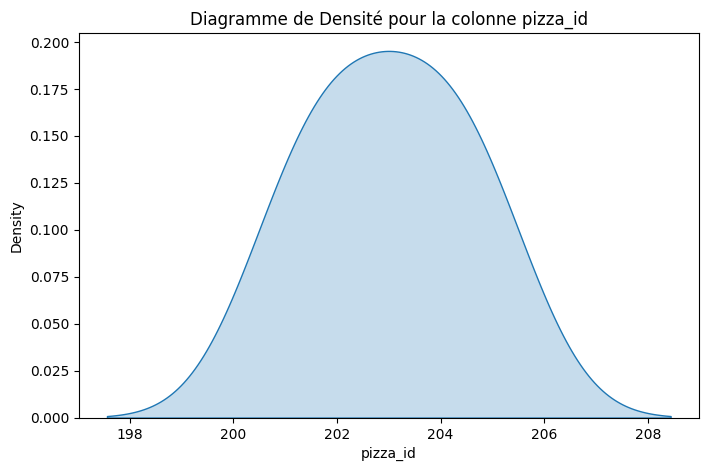


Résumé statistique complet :
count      5.000000
mean     203.000000
std        1.581139
min      201.000000
25%      202.000000
50%      203.000000
75%      204.000000
max      205.000000
Name: pizza_id, dtype: float64

Corrélation avec 'order_week' :
Corrélation : nan

Covariance avec 'order_week' :
Covariance : 0.0

Taille de l'échantillon :
Taille de l'échantillon : 5

Corrélation entre les colonnes :
                  order_details_id  order_id  pizza_id  quantity  unit_price  \
order_details_id          1.000000  1.000000  1.000000  0.693375    0.359717   
order_id                  1.000000  1.000000  1.000000  0.693375    0.359717   
pizza_id                  1.000000  1.000000  1.000000  0.693375    0.359717   
quantity                  0.693375  0.693375  0.693375  1.000000   -0.341087   
unit_price                0.359717  0.359717  0.359717 -0.341087    1.000000   
total_price               0.846412  0.846412  0.846412  0.949440   -0.031158   
order_month                   

<ipython-input-146-64e291e1d23a>:68: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())
<ipython-input-146-64e291e1d23a>:71: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.cov())
<ipython-input-146-64e291e1d23a>:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[column], kde=True, palette='viridis')


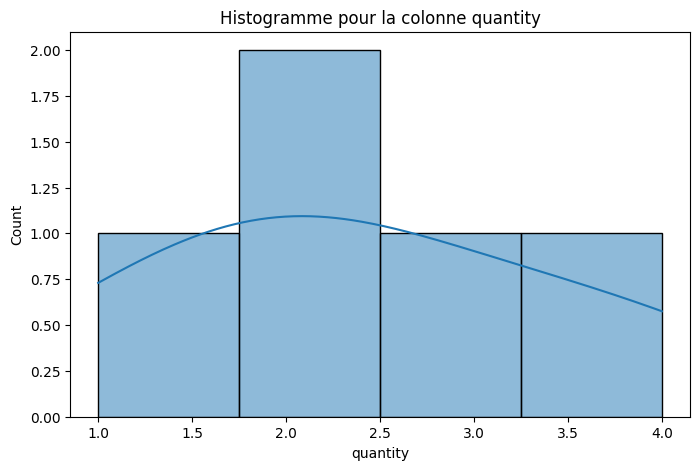

<ipython-input-146-64e291e1d23a>:51: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df[column], fill=True, palette='viridis')


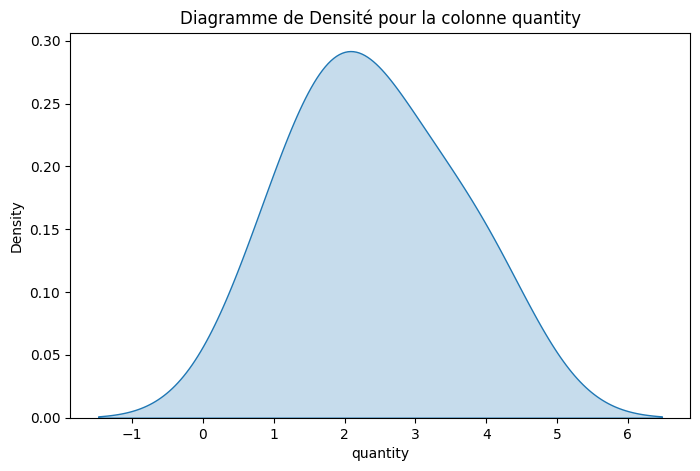


Résumé statistique complet :
count    5.000000
mean     2.400000
std      1.140175
min      1.000000
25%      2.000000
50%      2.000000
75%      3.000000
max      4.000000
Name: quantity, dtype: float64

Corrélation avec 'order_week' :
Corrélation : nan

Covariance avec 'order_week' :
Covariance : 0.0

Taille de l'échantillon :
Taille de l'échantillon : 5

Corrélation entre les colonnes :
                  order_details_id  order_id  pizza_id  quantity  unit_price  \
order_details_id          1.000000  1.000000  1.000000  0.693375    0.359717   
order_id                  1.000000  1.000000  1.000000  0.693375    0.359717   
pizza_id                  1.000000  1.000000  1.000000  0.693375    0.359717   
quantity                  0.693375  0.693375  0.693375  1.000000   -0.341087   
unit_price                0.359717  0.359717  0.359717 -0.341087    1.000000   
total_price               0.846412  0.846412  0.846412  0.949440   -0.031158   
order_month                    NaN       NaN  

<ipython-input-146-64e291e1d23a>:68: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())
<ipython-input-146-64e291e1d23a>:71: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.cov())


TypeError: Could not convert 2022-01-012022-01-022022-01-032022-01-042022-01-05 to numeric

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Remplacez 'df' par le nom de votre DataFrame
df = pd.DataFrame({
    'order_details_id': [1, 2, 3, 4, 5],
    'order_id': [101, 102, 103, 104, 105],
    'pizza_id': [201, 202, 203, 204, 205],
    'quantity': [2, 1, 3, 2, 4],
    'order_date': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05'],
    'order_time': ['12:00 PM', '1:30 PM', '6:45 PM', '9:15 AM', '3:30 PM'],
    'unit_price': [10.5, 12.0, 9.99, 14.75, 11.25],
    'total_price': [21.0, 12.0, 29.97, 29.5, 45.0],
    'pizza_size': ['Medium', 'Small', 'Large', 'Medium', 'Large'],
    'pizza_category': ['Vegetarian', 'Meat Lovers', 'Supreme', 'Vegetarian', 'Meat Lovers'],
    'pizza_ingredients': ['Mushrooms', 'Pepperoni', 'Onions', 'Olives', 'Sausage'],
    'pizza_name': ['Margherita', 'Pepperoni Feast', 'Supreme Deluxe', 'Vegetarian Delight', 'Meat Lovers Special'],
    'rounded_order_time': ['12:00 PM', '1:30 PM', '6:45 PM', '9:00 AM', '3:30 PM'],
    'year_month': ['2022-01', '2022-01', '2022-01', '2022-01', '2022-01'],
    'order_month': [1, 1, 1, 1, 1],
    'order_week': [1, 1, 1, 1, 1],
    'day_of_week': ['Friday', 'Saturday', 'Sunday', 'Monday', 'Wednesday'],
    'month': ['January', 'January', 'January', 'January', 'January']
})

# Appliquer différentes méthodes de statistiques descriptives sur chaque colonne
for column in df.columns:
    print(f"\nStatistiques descriptives pour la colonne '{column}':")

    print("\nMoyenne et Médiane :")
    print(f"Moyenne : {df[column].mean()}")
    print(f"Médiane : {df[column].median()}")

    print("\nÉcart-type et Somme :")
    print(f"Écart-type : {df[column].std()}")
    print(f"Somme : {df[column].sum()}")

    print("\nMin, Max et Valeurs uniques :")
    print(f"Valeur minimale : {df[column].min()}")
    print(f"Valeur maximale : {df[column].max()}")
    print(f"Valeurs uniques : {df[column].unique()}")

    print("\nHistogramme et Diagramme de Densité :")
    plt.figure(figsize=(8, 5))
    sns.histplot(df[column], kde=True, palette='viridis')
    plt.title(f'Histogramme pour la colonne {column}')
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.kdeplot(df[column], fill=True, palette='viridis')
    plt.title(f'Diagramme de Densité pour la colonne {column}')
    plt.show()

    print("\nRésumé statistique complet :")
    print(df[column].describe())

    print("\nCorrélation avec 'order_week' :")
    print(f"Corrélation : {df[column].corr(df['order_week'])}")

    print("\nCovariance avec 'order_week' :")
    print(f"Covariance : {df[column].cov(df['order_week'])}")

    print("\nTaille de l'échantillon :")
    print(f"Taille de l'échantillon : {df[column].size}")

    print("\nCorrélation entre les colonnes :")
    print(df.corr())

    print("\nCovariance entre les colonnes :")
    print(df.cov())
